In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

pd.options.display.max_columns = None # affiche toutes les colonnes lors de l'affichage des DataFrames
pd.options.display.float_format = '{:.2f}'.format # affiche les nombres à virgule flottante avec 2 décimales

# Import

In [2]:
# lecture des données de circulation :
df_raw = pd.read_parquet("../data/2-clean/circulations/slo_2024.parquet")

In [3]:
# lecture des données sur les gares :
gares = pd.read_parquet("../data/2-clean/gares/gares-de-voyageurs.parquet")

# Merge

In [4]:
df = df_raw.copy()

# Récupère les infos de la gare d'origine
df = (
    df.merge(gares[['code_ci', 'Segment(s) DRG', 'code_departement', 'nom_departement', 'region']], 
             left_on='code_ci_origine',
             right_on='code_ci',
             how='left')
    .rename(columns={
        'Segment(s) DRG': 'segment_DRG_origine', 
        'code_departement': 'code_dpt_origine', 
        'nom_departement': 'nom_dpt_origine', 
        'region': 'region_origine'})
    .drop(columns=['code_ci']))

# Récupère les infos de la gare de destination
df = (
    df.merge(gares[['code_ci', 'Segment(s) DRG', 'code_departement', 'nom_departement', 'region']],
             left_on='code_ci_destination', 
             right_on='code_ci',
             how='left')
    .rename(columns={
        'Segment(s) DRG': 'segment_DRG_destination',
        'code_departement': 'code_dpt_destination',
        'nom_departement': 'nom_dpt_destination',
        'region': 'region_destination'})
    .drop(columns=['code_ci'])
)

# Ajout de variables

In [5]:
jours_feries = pd.read_csv("../data/1-raw/jours_feries/jours_feries_metropole_2005_2030.csv", 
                           dtype={"annee": int, "nom_jour_ferie": str}, 
                           parse_dates=['date'])
df['is_jour_ferie'] = df['date_circ'].isin(jours_feries['date'])
del jours_feries

In [6]:
# Ré-ajout de la catégorie de retard à l'arrivée, supprimée de l'ingestion
bins = [float("-inf"), -10, -5, 0, 5, 10, 15, 30, 60, float("inf")]
labels = ["-10-", "[-10,-5[", "[-5,0[", "[0,5[", "[5,10[", "[10,15[", "[15,30[", "[30,60[", "[60+]"]
df["ret_arrivee_cat"] = pd.cut(df["ret_arrivee"], bins=bins, labels=labels, right=False)

# Analyse

In [7]:
# top 10 des plus grands retards à l'arrivée : 
df.sort_values(by='ret_arrivee', ascending=False).head() 

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,arrivee_theorique,arrivee_observe,distance_totale,ret_depart,ret_arrivee,ret_arrivee_5min,ret_arrivee_10min,ret_arrivee_15min,ret_arrivee_30min,ret_arrivee_60min,duree_theorique,duree_theorique_cat,duree_observee,mois,num_semaine,jour_semaine,heure_depart,heure_arrivee,segment_DRG_origine,code_dpt_origine,nom_dpt_origine,region_origine,segment_DRG_destination,code_dpt_destination,nom_dpt_destination,region_destination,is_jour_ferie,ret_arrivee_cat
99400,85272125,2024-05-24,5224,286005,Lille-Flandres,481002,Nantes,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-05-23 09:36:00,2024-05-24 09:35:46,2024-05-23 14:44:00,2024-05-24 14:41:04,704196,1439.77,1437.07,True,True,True,True,True,308.00,>3h,305.30,5,21,4,9,14,A,59,Nord,Hauts-de-France,A,44,Loire-Atlantique,Pays de la Loire,False,[60+]
63797,84338849,2024-04-03,8537,391003,Paris-Montparnasse,677005,Hendaye,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV - Atlantique, à charge",TGV2N2,TGV2N2,2024-04-03 10:04:00,2024-04-03 10:03:20,2024-04-03 14:47:00,2024-04-04 02:27:00,769999,-0.67,700.00,True,True,True,True,True,283.00,>3h,983.67,4,14,2,10,2,A,75,Paris,Ile-de-France,B,64,Pyrénées-Atlantiques,Nouvelle-Aquitaine,False,[60+]
159270,86872362,2024-08-17,4080,481002,Nantes,484006,Angers-St-Laud,OSLO,"GL Inter-Villes - Train classique, VL>= 160 km/h","GL Inter-Villes - Train classique, VL>= 160 km/h",22200,22200,2024-08-17 06:40:00,2024-08-17 06:39:37,2024-08-17 07:22:00,2024-08-17 18:15:42,87422,-0.38,653.70,True,True,True,True,True,42.00,<1h30,696.08,8,33,5,6,18,A,44,Loire-Atlantique,Pays de la Loire,A,49,Maine-et-Loire,Pays de la Loire,False,[60+]
144773,86491551,2024-07-26,7668,286542,Tourcoing,581009,Bordeaux-St-Jean,SNCF-VOYAGES,"TAGV haute capacité Nord, à charge","TAGV haute capacité Nord, à charge",TGVDAS,TGVDAS,2024-07-26 06:02:00,2024-07-26 10:42:00,2024-07-26 11:02:00,2024-07-26 21:16:13,918736,280.00,614.22,True,True,True,True,True,300.00,>3h,634.22,7,30,4,10,21,A,59,Nord,Hauts-de-France,A,33,Gironde,Nouvelle-Aquitaine,False,[60+]
144551,86489397,2024-07-26,5260,581009,Bordeaux-St-Jean,286005,Lille-Flandres,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-07-26 05:58:00,2024-07-26 05:58:01,2024-07-26 10:42:00,2024-07-26 20:31:13,888008,0.02,589.22,True,True,True,True,True,284.00,>3h,873.20,7,30,4,5,20,A,33,Gironde,Nouvelle-Aquitaine,A,59,Nord,Hauts-de-France,False,[60+]


In [8]:
# top 10 des plus grandes avances au départ
df.sort_values(by='ret_depart', ascending=True).head()

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,arrivee_theorique,arrivee_observe,distance_totale,ret_depart,ret_arrivee,ret_arrivee_5min,ret_arrivee_10min,ret_arrivee_15min,ret_arrivee_30min,ret_arrivee_60min,duree_theorique,duree_theorique_cat,duree_observee,mois,num_semaine,jour_semaine,heure_depart,heure_arrivee,segment_DRG_origine,code_dpt_origine,nom_dpt_origine,region_origine,segment_DRG_destination,code_dpt_destination,nom_dpt_destination,region_destination,is_jour_ferie,ret_arrivee_cat
29742,83385299,2024-02-11,6124,751081,Marseille-Blancarde,686006,Paris-Gare-de-Lyon,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-02-11 15:46:00,2024-02-10 15:32:28,2024-02-11 19:23:00,2024-02-11 19:26:51,753375,-1453.53,3.85,False,False,False,False,False,217.00,>3h,1674.38,2,6,6,15,19,B,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,A,75,Paris,Ile-de-France,False,"[0,5["
67789,84446252,2024-04-08,6689,722439,Givors-Canal,726000,St-Étienne-Châteaucreux,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-04-08 21:22:30,2024-04-08 06:35:59,2024-04-08 21:48:00,2024-04-08 21:48:16,37127,-886.52,0.27,False,False,False,False,False,25.50,<1h30,912.28,4,15,0,6,21,C,69,Rhône,Auvergne-Rhône-Alpes,B,42,Loire,Auvergne-Rhône-Alpes,False,"[0,5["
97350,85213756,2024-05-21,7106,343004,Valenciennes,271007,Paris-Nord,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGV-D,TGV-D,2024-05-21 06:57:00,2024-05-20 20:16:49,2024-05-21 08:49:00,2024-05-21 08:50:24,239453,-640.18,1.40,False,False,False,False,False,112.00,1h30-3h,753.58,5,21,1,20,8,B,59,Nord,Hauts-de-France,A,75,Paris,Ile-de-France,False,"[0,5["
22249,83177938,2024-02-03,6250,688887,Montpellier (CNM),686006,Paris-Gare-de-Lyon,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-02-03 07:52:00,2024-02-02 22:40:27,2024-02-03 11:04:00,2024-02-03 11:20:57,731079,-551.55,16.95,True,True,True,False,False,192.00,>3h,760.50,2,5,5,22,11,A,34,Hérault,Occitanie,A,75,Paris,Ile-de-France,False,"[15,30["
101138,85319775,2024-05-26,6180,756056,Nice-Ville,686006,Paris-Gare-de-Lyon,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-05-26 16:58:00,2024-05-26 07:57:55,2024-05-26 22:38:00,2024-05-26 23:13:59,971692,-540.08,35.98,True,True,True,True,False,340.00,>3h,916.07,5,21,6,7,23,A,06,Alpes-Maritimes,Provence-Alpes-Côte d'Azur,A,75,Paris,Ile-de-France,False,"[30,60["


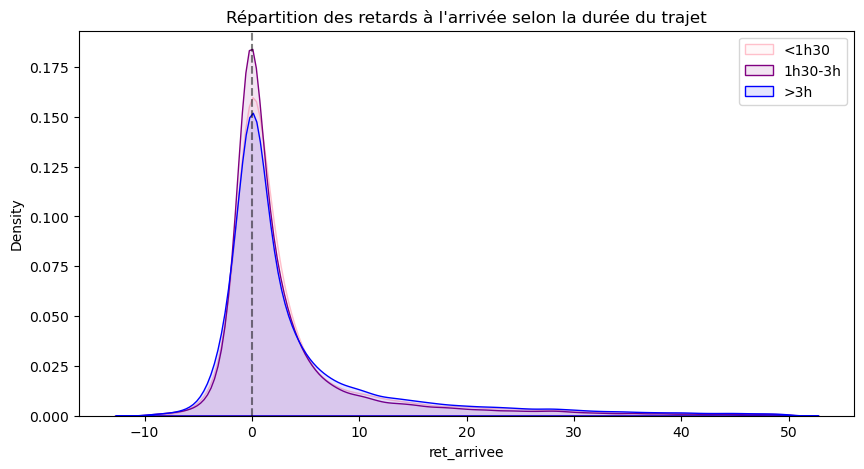

In [9]:
# Répartition des retards à l'arrivée selon la durée du Trajet
plt.figure(figsize=(10,5))
sns.kdeplot(data=df[(df['ret_arrivee'] >= -10) & (df['ret_arrivee'] <= 50) & (df['duree_theorique_cat'] == '<1h30')], x='ret_arrivee', fill=True, color='pink', alpha=0.1)
sns.kdeplot(data=df[(df['ret_arrivee'] >= -10) & (df['ret_arrivee'] <= 50) & (df['duree_theorique_cat'] == '1h30-3h')], x='ret_arrivee', fill=True, color='purple', alpha=0.1)
sns.kdeplot(data=df[(df['ret_arrivee'] >= -10) & (df['ret_arrivee'] <= 50) & (df['duree_theorique_cat'] == '>3h')], x='ret_arrivee', fill=True, color='blue', alpha=0.1)
plt.legend(['<1h30', '1h30-3h', '>3h'])
plt.title("Répartition des retards à l'arrivée selon la durée du trajet")
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# constat : les trains de 3 h sont légèrement plus en retard (autant au départ qu'à l'arrivée), mais c'est subtil

Text(0.5, 1.0, "Répartition des retards au départ et à l'arrivée ")

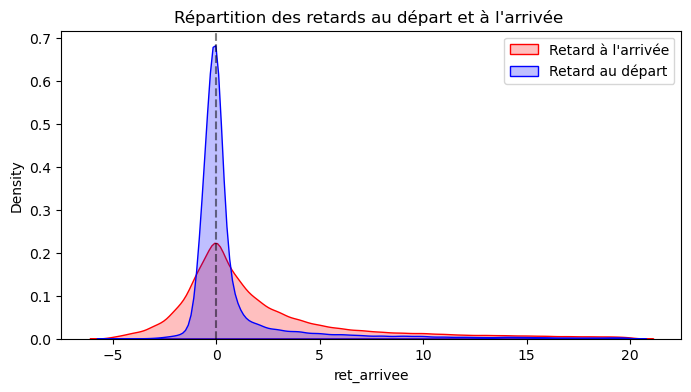

In [10]:
# Réparatition des retards au départ et à l'arrivée
plt.figure(figsize=(8,4))
sns.kdeplot(df[(df['ret_arrivee'] >= -5) & (df['ret_arrivee'] <= 20)]['ret_arrivee'], fill=True, bw_adjust=1, color='r')
sns.kdeplot(df[(df['ret_depart'] >= -5) & (df['ret_depart'] <= 20)]['ret_depart'], fill=True, bw_adjust=1, color='b')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.legend(["Retard à l'arrivée", "Retard au départ"])
plt.title("Répartition des retards au départ et à l'arrivée ")

# Constats : 
# - les trains sont nettement plus ponctuels au départ qu'à l'arrivée, indiquant une possible accumulation de retard au fil du trajet.
# - distribution asymétrique à droite : les trains sont plus souvent en retard (x>0) qu'en avance (x<0).

Text(0.5, 1.0, "Répartition des retards à l'arrivée selon la durée du trajet")

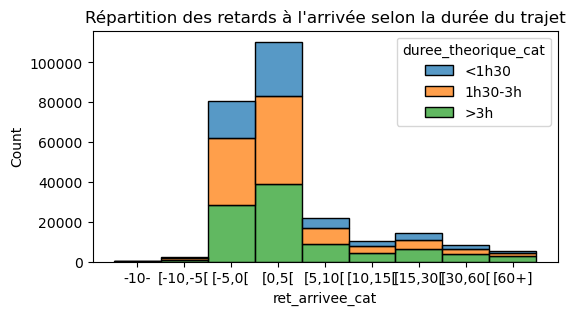

In [11]:
# Répartition des retards à l'arrivée selon la durée du trajet
plt.figure(figsize=(6,3))
sns.histplot(data=df, x="ret_arrivee_cat", hue="duree_theorique_cat", multiple="stack", stat="count")
plt.title("Répartition des retards à l'arrivée selon la durée du trajet")

Text(0.5, 1.0, "Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée")

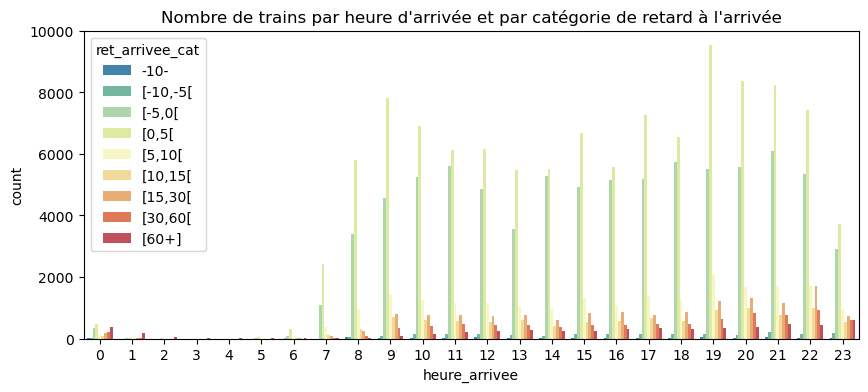

In [12]:
# Affiche le nombre de ret_arrivee_cat par heure_arrivee
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='heure_arrivee', hue='ret_arrivee_cat', palette=palette)
plt.title("Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée")

Text(0.5, 1.0, "Nombre de trains par mois et par catégorie de retard à l'arrivée")

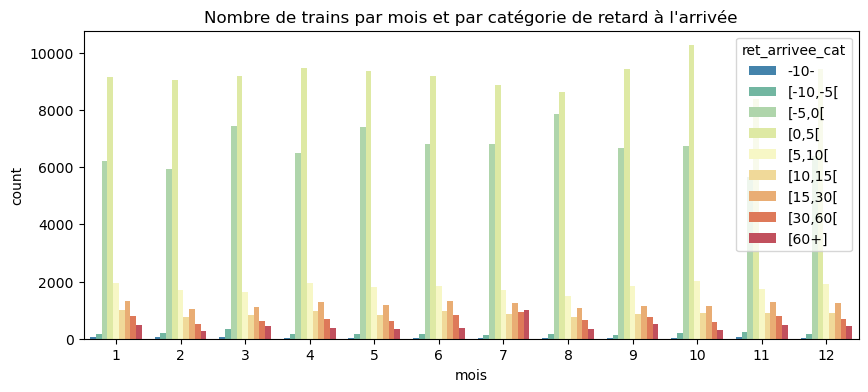

In [13]:
# Affiche le nombre de ret_arrivee_cat par mois
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='mois', hue='ret_arrivee_cat', palette=palette)
plt.title("Nombre de trains par mois et par catégorie de retard à l'arrivée")

# Retard selon région, axe

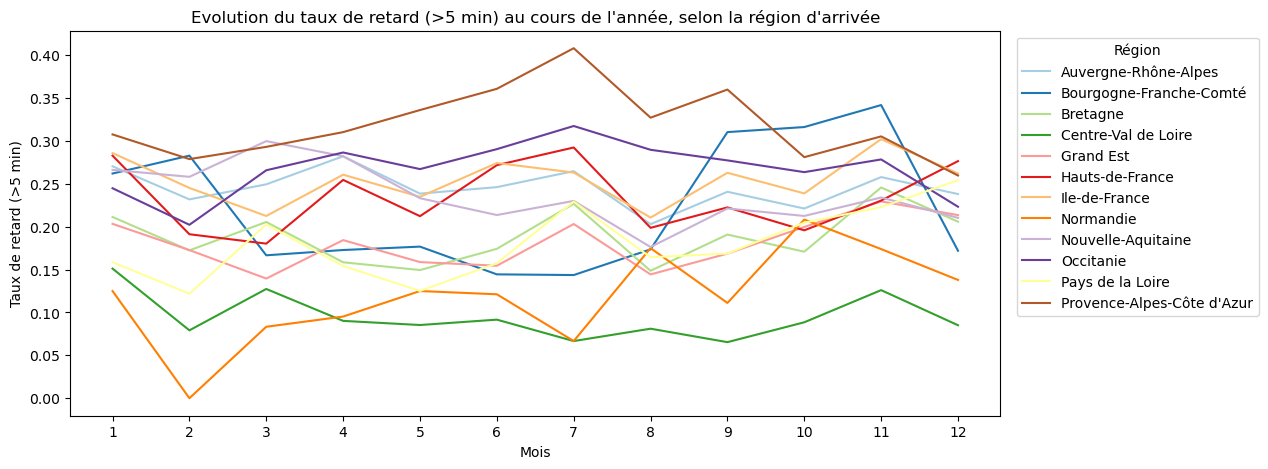

In [14]:
# Evolution des retards à l'arrivée au cours de l'année, selon la région d'arrivée
retard_5min_mensuel = df.groupby(['mois', 'region_destination']).agg(
    taux_retard = ('ret_arrivee_5min', 'mean'),
    region = ('region_destination', 'first')
)
retard_5min_mensuel.reset_index(inplace=True)
retard_5min_mensuel['mois'] = retard_5min_mensuel['mois'].astype(str)
plt.figure(figsize=(12, 5))
sns.lineplot(data=retard_5min_mensuel, x='mois', y='taux_retard', hue='region', palette='Paired')
plt.title("Evolution du taux de retard (>5 min) au cours de l'année, selon la région d'arrivée")
plt.xlabel("Mois")
plt.ylabel("Taux de retard (>5 min)")
plt.legend(title='Région', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()


In [15]:
# Taux de retard à l'arrivée, selon la région d'arrivée
retard_5min_mensuel = df.groupby(['region_destination']).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).reset_index()
retard_5min_mensuel.sort_values(by='taux_retard_15min', ascending=False).style.background_gradient(cmap='coolwarm')

,region_destination,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
11,Provence-Alpes-Côte d'Azur,9.491596,1.900000,0.320534,0.215991,0.163913,0.081311,0.033299,15496
9,Occitanie,6.928334,0.166667,0.268192,0.186060,0.142466,0.073098,0.029173,12066
5,Hauts-de-France,6.203658,0.933333,0.234049,0.162644,0.119956,0.059508,0.021487,35138
6,Ile-de-France,6.464102,1.183333,0.254142,0.159702,0.113890,0.054688,0.020725,97225
0,Auvergne-Rhône-Alpes,6.043216,1.116667,0.245446,0.147402,0.106343,0.049121,0.016044,25305
7,Normandie,2.631004,-2.000000,0.121118,0.105590,0.102484,0.049689,0.015528,322
1,Bourgogne-Franche-Comté,5.804604,0.900000,0.213514,0.129730,0.101622,0.046486,0.017297,1850
10,Pays de la Loire,5.656788,0.000000,0.180462,0.125629,0.096044,0.051709,0.024206,11526
8,Nouvelle-Aquitaine,5.641560,0.533333,0.235862,0.136307,0.092191,0.043907,0.020286,14394
2,Bretagne,5.406992,0.000000,0.188087,0.119498,0.091403,0.047975,0.020980,13632


In [16]:
# Taux de retard_5min par axe & type de train (lib_tct_arrivee)
retard_par_libtct = df.groupby('lib_tct_arrivee').agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).reset_index()
retard_par_libtct.sort_values(by='taux_retard_5min', ascending=False)

,lib_tct_arrivee,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
20,Voyageurs internationaux - VL<160km/h non TAGV...,25.16,5.10,0.51,0.44,0.39,0.27,0.17,190
16,"TAGV international France Angleterre, à charge",7.29,2.17,0.34,0.21,0.15,0.06,0.02,928
17,"TAGV spéciaux nationaux (pèlerins et autres), ...",10.28,2.00,0.33,0.23,0.19,0.13,0.07,271
8,"TAGV International France Espagne, à charge",8.34,1.58,0.33,0.22,0.16,0.07,0.03,1588
9,"TAGV International France Italie, à charge",7.31,2.30,0.31,0.17,0.10,0.05,0.02,1009
11,"TAGV International France-Espagne, à charge",7.74,1.67,0.30,0.18,0.12,0.07,0.02,1421
14,"TAGV haute capacité Nord, à charge",8.92,1.23,0.30,0.21,0.16,0.08,0.03,5668
7,"TAGV International France Allemagne, à charge",6.91,1.28,0.29,0.19,0.13,0.06,0.02,7790
2,TAGV (Train A Grande Vitesse - à charge),7.02,1.18,0.28,0.20,0.15,0.07,0.02,33934
15,"TAGV haute capacité Sud-Est, à charge",7.87,1.13,0.27,0.18,0.14,0.07,0.03,6467


In [17]:
# Taux de retard TAGV par axe majeur DEPUIS PARIS
TAGV_depuis_paris = df[df['lib_ci_origine'].str.startswith("Paris") & df['lib_tct_arrivee'].str.startswith("TAGV")].copy()
TAGV_depuis_paris['lib_tct_arrivee'].value_counts()
TAGV_depuis_paris['Axe'] = TAGV_depuis_paris['lib_tct_arrivee'].map({
    'TAGV - Sud-Est, à charge': 'Sud-Est',
    'TAGV - Atlantique, à charge': 'Atlantique',
    'TAGV (Train A Grande Vitesse - à charge)': 'Inconnu',
    'TAGV - Est, à charge': 'Est',
    'TAGV - Nord, à charge': 'Nord',
    'TAGV International France Suisse, à charge': 'Suisse',
    'TAGV, axe Bretagne, à charge': 'Bretagne',
    'TAGV International France Allemagne, à charge': 'Allemagne',
    'TAGV haute capacité Sud-Est, à charge': 'Sud-Est (HC)',
    'TAGV haute capacité Atlantique, à charge': 'Atlantique (HC)',
    'TAGV International France Espagne, à charge': 'Espagne',
    'TAGV haute capacité Est, à charge': 'Est (HC)',
    'TAGV International France Italie, à charge': 'Italie',
    'TAGV international France Angleterre, à charge': 'Angleterre'
})
# tous les trains d'axe 'inconnu' sont en fait opérés par Thalys ou Trenitalia
# on va leur faire des catégories plus précises en fonction de leur département de destination
TAGV_depuis_paris.loc[
    (TAGV_depuis_paris['Axe'] == 'Inconnu') & (TAGV_depuis_paris['region_destination'] == 'Hauts-de-France'), 
    'Axe'
] = 'Nord (Thalys)'
TAGV_depuis_paris.loc[
    (TAGV_depuis_paris['Axe'] == 'Inconnu') & (TAGV_depuis_paris['region_destination'] == 'Auvergne-Rhône-Alpes'), 
    'Axe'
] = 'Sud-Est (Trenitalia)'

retard_par_axe = TAGV_depuis_paris.groupby('Axe').agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
retard_par_axe.reset_index(inplace=True)
retard_par_axe.sort_values(by='taux_retard_15min', ascending=False, inplace=True)
retard_par_axe.style.background_gradient(cmap='coolwarm')

# constats :
# - trains haute capacité (HC) sont moins ponctuels que trains classiques
# - lignes internationales plus en retard que lignes nationales : Angleterre, Espagne, Italie...
# - à l'excpetion de la Suisse et Allemagne
# - axes les plus ponctuels : Trenitalia, Est, Nord, 

,Axe,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
1,Angleterre,8.734831,2.408333,0.363281,0.238281,0.175781,0.093750,0.023438,256
5,Espagne,7.700719,1.125000,0.319797,0.223350,0.167513,0.067259,0.026650,788
12,Sud-Est (HC),8.103272,1.166667,0.276173,0.186393,0.139795,0.074868,0.025784,3219
3,Atlantique (HC),7.556236,0.000000,0.235466,0.163040,0.127314,0.076648,0.042546,3079
14,Suisse,6.474694,1.083333,0.232376,0.156977,0.121185,0.053961,0.017805,5504
10,Nord (Thalys),5.708909,0.583333,0.199094,0.148338,0.119542,0.065026,0.022644,11703
7,Est (HC),5.147599,-0.366667,0.170629,0.127273,0.110490,0.067133,0.026573,715
11,Sud-Est,6.040857,0.883333,0.232480,0.147262,0.108160,0.053360,0.019273,21533
8,Italie,7.913400,3.000000,0.306818,0.164773,0.105114,0.051136,0.014205,352
4,Bretagne,5.667675,0.000000,0.186506,0.124079,0.099263,0.052927,0.022877,5158


In [18]:
# gares d'arrivée les plus populaires
df['lib_ci_destination'].value_counts()

lib_ci_destination
Paris-Gare-de-Lyon    32805
Paris-Montparnasse    26759
Paris-Nord            19262
Paris-Est             15149
Wannehain             13027
                      ...  
Troyes                    1
St-Claude                 1
Rives                     1
Albi-Ville                1
Belfort                   1
Name: count, Length: 228, dtype: Int64

In [19]:
# Taux de retard parmi les n gares d'arrivée les plus courantes -> #TODO utiliser plutot le segment DRG issu de "gares"
n = 50
top_n_gares = df['lib_ci_destination'].value_counts().head(n).index
retard_5min_gare = df[df['lib_ci_destination'].isin(top_n_gares)].groupby('lib_ci_destination').agg(
    retard_median = ('ret_arrivee', 'median'),
    retard_moyen = ('ret_arrivee', 'mean'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nombre_circulations = ('id_circ', 'count')
    ).sort_values(by='taux_retard_5min', ascending=False)
retard_5min_gare.head(10).style.background_gradient(cmap='coolwarm')

,retard_median,retard_moyen,taux_retard_5min,taux_retard_10min,taux_retard_15min,nombre_circulations
lib_ci_destination,,,,,,
Nice-Ville,3.291667,13.225772,0.410664,0.276661,0.212172,3582
Lyon-Part-Dieu,2.566667,8.289871,0.328217,0.185013,0.132700,4951
Paris-Nord,2.083333,7.890378,0.324836,0.218928,0.157305,19262
Grenoble,2.000000,7.565985,0.318091,0.195347,0.141195,2493
Montpellier-St-Roch,0.666667,8.538134,0.305556,0.224034,0.176932,1656
Montpellier (CNM),1.183333,7.517482,0.304018,0.190675,0.137604,2638
Marseille-St-Charles,1.666667,8.592354,0.302925,0.202652,0.153935,9504
St-Étienne-Châteaucreux,1.541667,5.737628,0.281199,0.136953,0.086710,1234
Bordeaux-St-Jean,1.350000,6.771718,0.272837,0.159341,0.109547,5824


# TODO à réorganiser

In [20]:
# Taux de retard en fonction de la longueur du trajet (distance_totale)
# sns.scatterplot(data=df, x='distance_totale', y='ret_arrivee', alpha=0.1)
# plt.title("Retard à l'arrivée en fonction de la longueur du trajet")
# à première vue, pas de corrélation nette entre distance et retard.
# néanmoins, graphique peu lisible car trop de points, on ne réalise pas bien la densité.
# voir taux de retard selon la distance plus bas

Text(500, 450, 'f(x)=x')

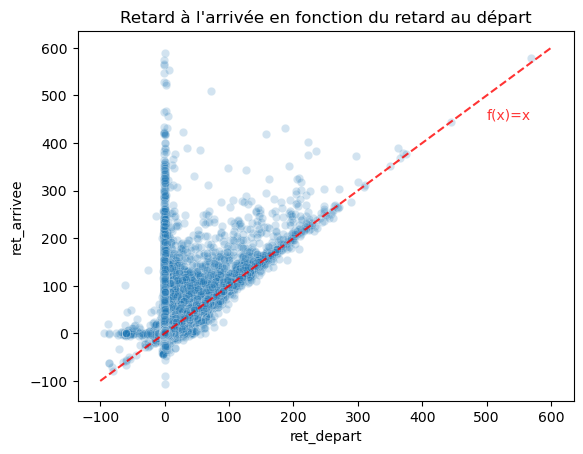

In [21]:
# Retard à l'arrivée en fonction du retard au départ
sns.scatterplot(data=df[(df['ret_depart'] > -100) & (df['ret_arrivee'] < 600)], x='ret_depart', y='ret_arrivee', alpha=0.2)
# constat : 
# - ligne verticale à x=0 : trains l'heure au départ, mais avec du retard à l'arrivée 
# - droite oblique : les trains qui ont conservé leur retard initial.
# - f(x)<x (sous la droite rouge) : trains qui ont récupéré un petit peu de leur retard initial 
# - f(x)>x (au dessus de la droite): les trains qui ont pris du retard au cous du trajet, en plus de leur retard initial.

# trace f(x) = x
plt.plot([-100, 600], [-100, 600], color='red', linestyle='--', alpha=0.8)
plt.title("Retard à l'arrivée en fonction du retard au départ")
plt.text(500, 450, "f(x)=x", color='red', alpha=0.8)

In [22]:
# Taux de retard selon le département de destination
retard_par_departement = df.groupby('code_dpt_destination').agg(
    nom_departement = ('nom_dpt_destination', 'first'),
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    nb_circulations = ('id_circ', 'count')
)
retard_par_departement.head(10)

,nom_departement,retard_arrivee_moyen,retard_arrivee_median,nb_circulations
code_dpt_destination,,,,
01,Ain,7.49,1.50,2732
02,Aisne,-0.85,-0.85,1
03,Allier,2.84,2.00,19
05,Hautes-Alpes,67.00,67.00,2
06,Alpes-Maritimes,13.38,3.32,3589
08,Ardennes,3.87,0.17,739
10,Aube,2.50,3.00,4
11,Aude,48.30,2.44,10
13,Bouches-du-Rhône,8.57,1.70,10210


In [23]:
# Taux de retard à l'arrivée par région d'arrivée
retard_par_region = df.groupby('region_destination').agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nb_circulations = ('id_circ', 'count')
).reset_index()
retard_par_region.sort_values(by='taux_retard_15min', ascending=False).style.background_gradient(cmap='coolwarm')

,region_destination,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,nb_circulations
11,Provence-Alpes-Côte d'Azur,9.491596,1.900000,0.320534,0.215991,0.163913,15496
9,Occitanie,6.928334,0.166667,0.268192,0.186060,0.142466,12066
5,Hauts-de-France,6.203658,0.933333,0.234049,0.162644,0.119956,35138
6,Ile-de-France,6.464102,1.183333,0.254142,0.159702,0.113890,97225
0,Auvergne-Rhône-Alpes,6.043216,1.116667,0.245446,0.147402,0.106343,25305
7,Normandie,2.631004,-2.000000,0.121118,0.105590,0.102484,322
1,Bourgogne-Franche-Comté,5.804604,0.900000,0.213514,0.129730,0.101622,1850
10,Pays de la Loire,5.656788,0.000000,0.180462,0.125629,0.096044,11526
8,Nouvelle-Aquitaine,5.641560,0.533333,0.235862,0.136307,0.092191,14394
2,Bretagne,5.406992,0.000000,0.188087,0.119498,0.091403,13632


In [24]:
# Taux de retard à l'arrivée par région d'origine
retard_par_region = df.groupby('region_origine').agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nb_circulations = ('id_circ', 'count')
).reset_index()
retard_par_region.sort_values(by='taux_retard_15min', ascending=False).style.background_gradient(cmap='coolwarm')

,region_origine,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,nb_circulations
7,Normandie,13.884528,3.266667,0.408100,0.264798,0.208723,321
11,Provence-Alpes-Côte d'Azur,8.949401,1.883333,0.333114,0.220188,0.160466,15187
9,Occitanie,9.328865,1.900000,0.323745,0.209262,0.152727,12028
5,Hauts-de-France,7.659041,1.716667,0.306147,0.205159,0.148202,36133
0,Auvergne-Rhône-Alpes,5.898139,1.050000,0.241345,0.149489,0.107119,25159
4,Grand Est,5.598806,0.966667,0.231847,0.141208,0.099757,23908
10,Pays de la Loire,6.703260,0.550000,0.200585,0.130439,0.099122,10250
8,Nouvelle-Aquitaine,6.237839,1.233333,0.251765,0.144904,0.098225,14589
6,Ile-de-France,5.359728,0.416667,0.198899,0.130652,0.097910,97733
2,Bretagne,5.496873,0.500000,0.196639,0.122126,0.089180,13568


# Taux de corrélation (heatmap)

In [25]:
# encodage des variables catégorielles
df_encoded = df.copy()
df_encoded = df_encoded.drop(columns=['ret_arrivee_cat']) 
for col in df_encoded.select_dtypes(include=['object','string','category']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# calcul des corrélations
df_encoded_corr = df_encoded.corr()

Text(0.5, 1.0, 'Heatmap de corrélation entre le variables')

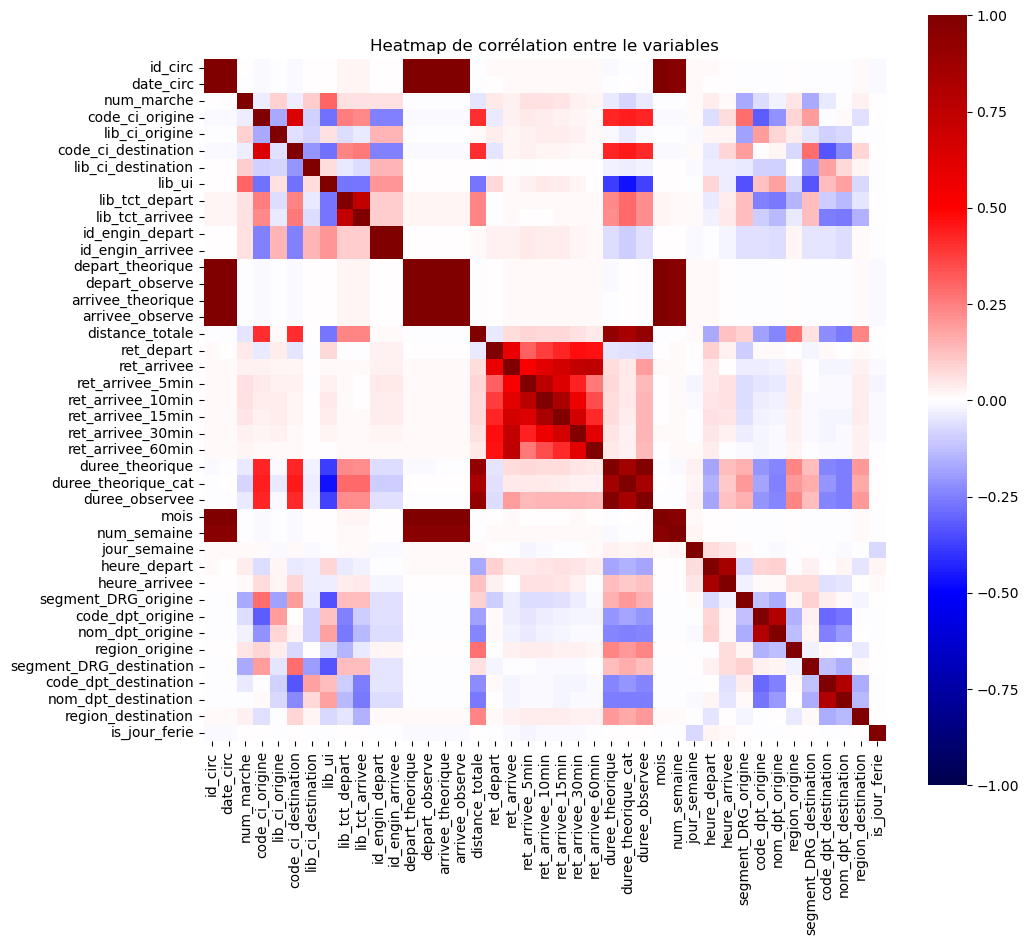

In [26]:
# heatmap de corrélation
plt.figure(figsize=(11, 10))
plt.gca().set_aspect('equal', adjustable='box')
sns.heatmap(df_encoded_corr, annot=False, fmt=".2f", cmap="seismic", vmax=1, vmin=-1, annot_kws={"size": 5})
plt.title("Heatmap de corrélation entre le variables")

# constat : le retard à l'arrivée n'a aucune corrélation significative avec des variables comme la région (0.03), 
# le num_marche (0.05), id_engin (0.04), lib_ui (0.04), etc.

# la distance totale (0.07), la durée théorique (0.07), et la durée observée (0.14) on également une corrélation assez faible.

# la seule corrélation notable serait le retard au départ (environ 0.6 selon la métrique utilisée : retard moyen, taux de retard à 5min, etc).
# Notons que, si l'objectif est de prédire le retard d'un train, le retard au départ et la durée observée du trajet 
# ne sont pas connus à l'avance, et donc pas utilisables comme variables prédictives.

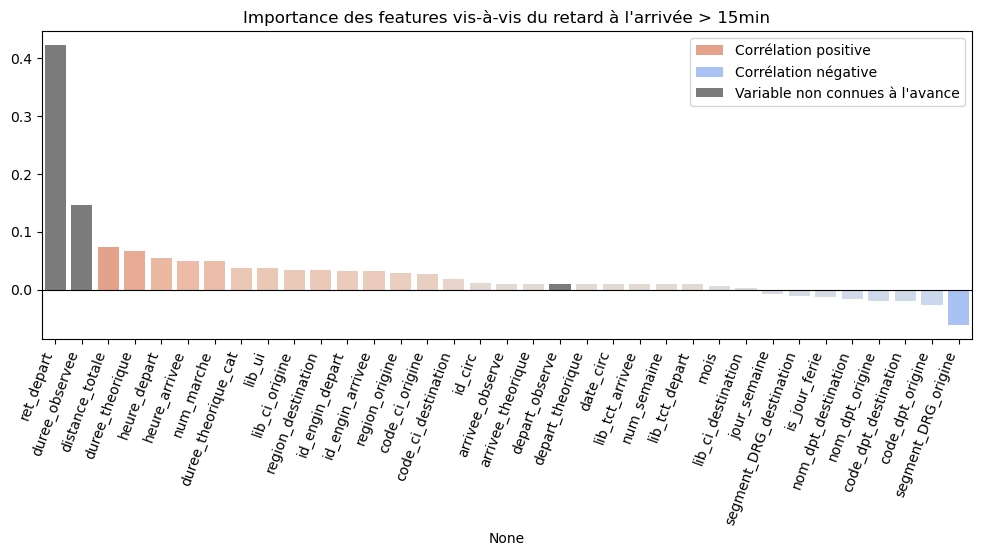

In [27]:
# Importance des features vis-à-vis du retard à l'arrivée > 15min

corr_series = df_encoded_corr.loc["ret_arrivee_15min"].sort_values(ascending=False)

# on exclut les colonnes non pertinentes (directement liées au retard à l'arrivée) :
corr_series = corr_series.drop(["ret_arrivee_60min", "ret_arrivee_30min", "ret_arrivee_15min", "ret_arrivee_10min", "ret_arrivee_5min", "ret_arrivee"], errors='ignore')

# dégradé de couleurs
norm = plt.Normalize(-0.15, 0.15)
colors = (plt.cm.coolwarm(norm(corr_series.values))).tolist()

# on passe en gris les colonnes non connues à l'avance 
unknown_cols = ["ret_depart", "duree_observee", "depart_observe", 'arrivee_observee']
for i, col in enumerate(corr_series.index):
    if col in unknown_cols:
        colors[i] = ("#7B7B7B")

plt.figure(figsize=(12, 4))
sns.barplot(
    x=corr_series.index,
    y=corr_series.values,
    hue=corr_series.index,
    palette=colors
)
plt.xticks(rotation=70, ha='right')
plt.title("Importance des features vis-à-vis du retard à l'arrivée > 15min")
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

# Légende
legend_elements = [
    Patch(facecolor="#e5a28a", label='Corrélation positive'),
    Patch(facecolor="#a9c1f3", label='Corrélation négative'),
    Patch(facecolor="#7B7B7B", label='Variable non connues à l\'avance')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()


In [28]:
# Taux de retard selon segment_DRG_origine
stats = df.groupby(["segment_DRG_origine"], observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).reset_index()
stats.style.background_gradient(cmap='coolwarm')
# mouais, pas convaincu de cette corrélation là

,segment_DRG_origine,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
0,A,5.976879,0.750000,0.222198,0.142173,0.104257,0.052010,0.020660,203287
1,B,5.695131,1.333333,0.239009,0.131888,0.088636,0.042185,0.016056,16878
2,C,5.770377,0.566667,0.208067,0.132907,0.093454,0.052898,0.020939,4537


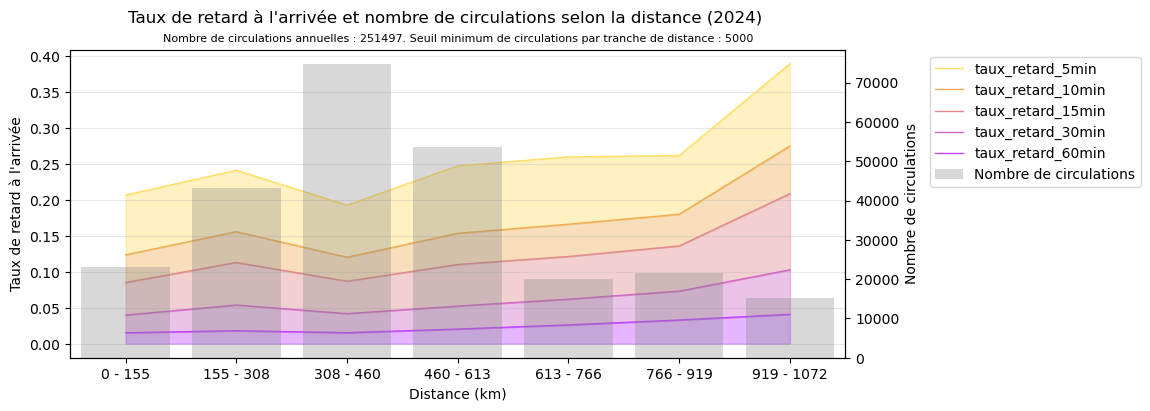

In [29]:
# Taux de ratrd selon la distance
df_copy = df.copy()
# Répartition des distances totales
# df_copy['distance_totale'].plot(kind='hist', bins=20)

seuil_trajets = 5000 # nombre minimal de trajets pour considérer la donnée comme pertinente

# Ajout d'une variable catégorielle pour la distance
df_copy['distance_totale_cat'] = pd.cut(df_copy['distance_totale'], bins=10)

# Probabilité d'être en retard à l'arrivée selon la distance
stats = df_copy.groupby(["distance_totale_cat"], observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

stats = stats.reset_index()

# élimine les tranches de distance avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets]

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la distance (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche de distance : {seuil_trajets}", fontsize=8)
plt.xlabel("Distance (km)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = [f"{int(interval.left/1000)} - {int(interval.right/1000)}" for interval in stats["distance_totale_cat"]]
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()

# constat : le taux de retard semble légèrement augmenter avec la distance

# Retard selon heure, jour, semaine, mois, vacances & jours fériés

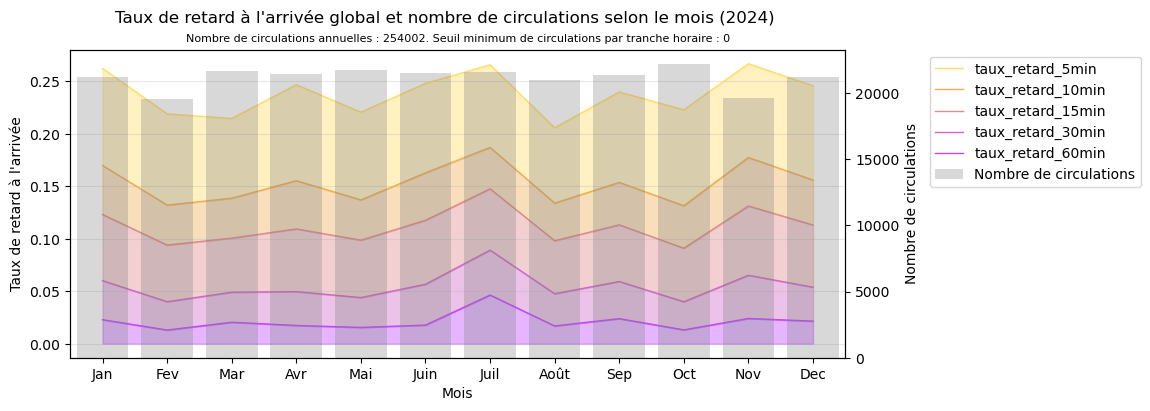

In [30]:
### Taux de retard à l'arrivée global et nombre de circulations selon le mois (2024)

seuil_trajets_annuels_mini = 0

# Probabilité d'être en retard à l'arrivée selon le mois
stats = df.groupby(["mois"]).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère le mois comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le mois (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Mois")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

# constat : voir l'analyse semaine par semaine, on comprend pourquoi juillet et novembre ont autant de retard (en plus des retards habituels...) : sabotage, tempêtes

plt.show()

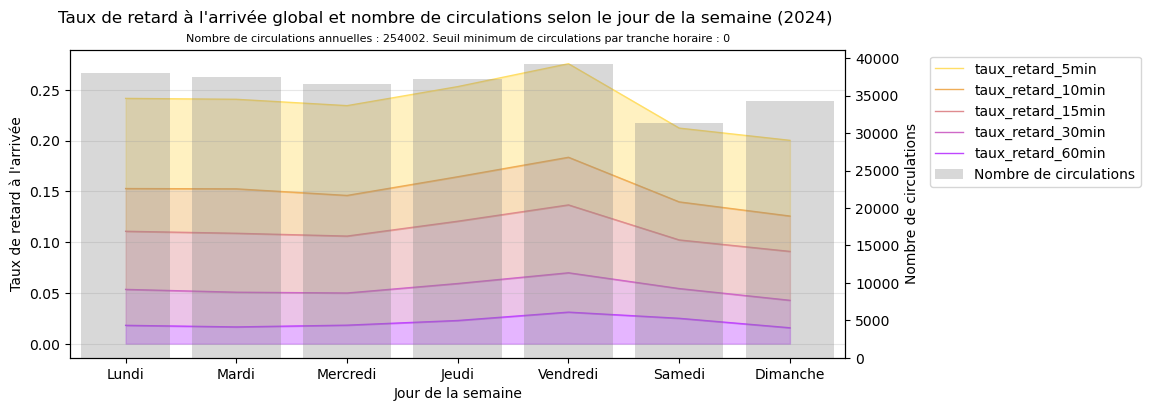

In [31]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine (2024)

seuil_trajets_annuels_mini = 0

# Probabilité d'être en retard à l'arrivée selon le jour de la semaine
stats = df.groupby(["jour_semaine"]).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère le jour de la semaine comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Jour de la semaine")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()

# constat : taux de retard plus élevé le vendredi, plus faible le weekend

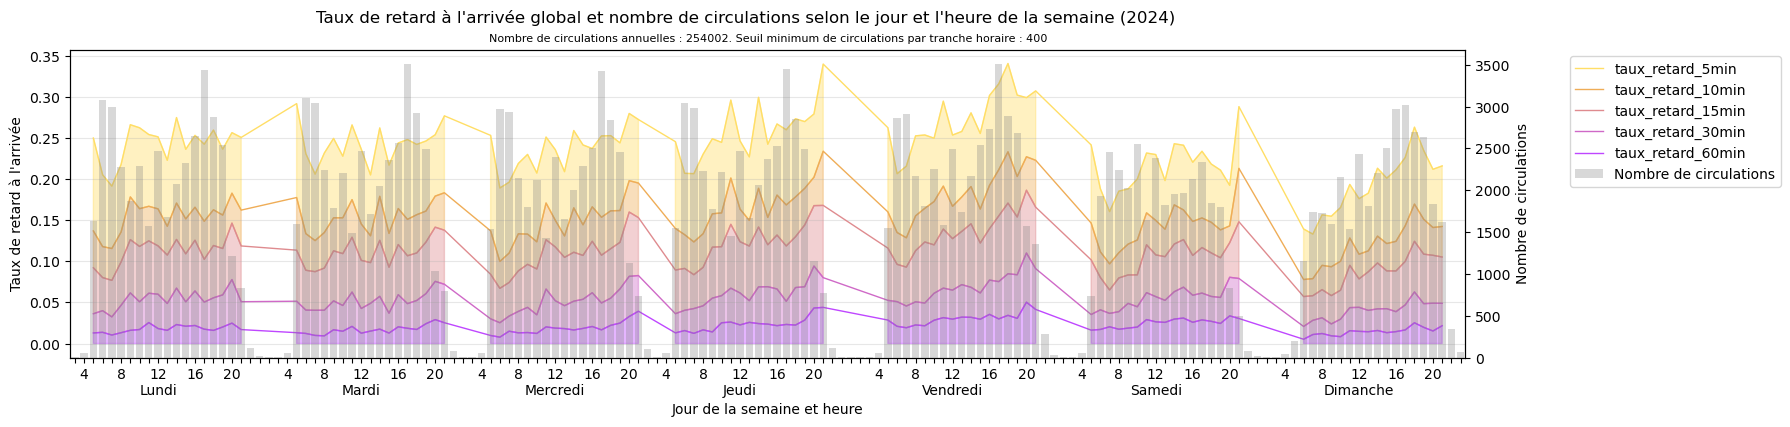

In [32]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine ET l'heure de départ (2024)

seuil_trajets_annuels_mini = 400

# Probabilité d'être en retard à l'arrivée selon le jour et l'heure de la semaine 
stats = df.groupby(["jour_semaine", "heure_depart"]).agg(
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
stats = stats.reset_index(names=['jour_semaine','heure_depart'])

# quand le nb_circ < seuil, on va ici remplaver la valeur des taux de retard par NaN 
# (pour ne pas afficher les taux sur ces plages horaires, qui sont biaisés par le faible nombre de trajets)
stats.loc[stats["nb_circ"] < seuil_trajets_annuels_mini,
          ["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
           "taux_retard_30min", "taux_retard_60min"]] = np.nan

# Graphique
plt.figure(figsize=(18, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le jour et l'heure de la semaine (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Jour de la semaine et heure")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min", 
                         "taux_retard_30min", "taux_retard_60min"]],
            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(range(len(stats)), stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Axe secondaire
ax2 = ax.twinx()
sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende unifiée
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.07, 1))

# Labels
heures_interet = [4, 8, 12, 16, 20]
jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
x_labels = []
for ligne in stats.values:
    jour_num, heure = ligne[0], ligne[1]
    heure_label = f"{heure:.0f}" if heure in heures_interet else ""
    x_labels.append(f"{heure_label}\n{jours_semaine[int(jour_num)] if heure == 12 else ""}")
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()


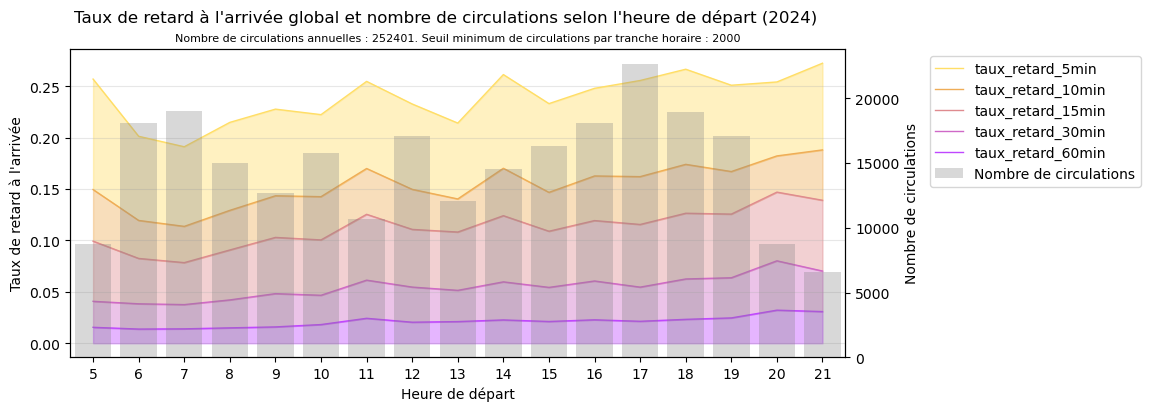

In [33]:
### Taux de retard à l'arrivée global et nombre de circulations selon l'heure de départ (2024)

seuil_trajets_annuels_mini = 2000

# Probabilité d'être en retard à l'arrivée selon l'heure de départ 
stats = df.groupby(["heure_depart"]).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère l'heure comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon l'heure de départ (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Heure de départ")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# Constat : les trains du matin (6-8h) sont globalement plus ponctuels que les trains du soir (17-21h)

# Note qui explique peut-être la différence avec les réusltats présentés par Le Monde : je considère uniquement les terminus, pas les arrêts intermédiaires. 
# et je considère tous les trains SLO, y compris des trains qui ne sont pas des TAGV (même s'ils sont minoritaires dans la base de données)

In [34]:
# Cas d'usages : taux de retard par heure selon la ville de départ et d'arrivée

def plot_retard_par_heure(depart, arrivée, seuil_trajets_annuels_mini=100):

    trajets_casdusage = df[(df["lib_ci_origine"].str.startswith(depart)) & (df["lib_ci_destination"].str.startswith(arrivée))]

    # Probabilité d'être en retard à l'arrivée selon l'heure de départ 
    stats = trajets_casdusage.groupby(["heure_depart"]).agg(
        retard_arrivee_moyen = ('ret_arrivee', 'mean'),
        retard_arrivee_median = ('ret_arrivee', 'median'),
        taux_retard_5min = ('ret_arrivee_5min', 'mean'),
        taux_retard_10min = ('ret_arrivee_10min', 'mean'),
        taux_retard_15min = ('ret_arrivee_15min', 'mean'),
        taux_retard_30min = ('ret_arrivee_30min', 'mean'),
        taux_retard_60min = ('ret_arrivee_60min', 'mean'),
        nb_circ = ('id_circ', 'count')
    )

    # élimine les heures avec peu de circulations pour éviter le bruit
    stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

    # considère l'heure comme une chaine de caractères (pour l'affichage)
    stats.index = stats.index.astype(str)

    # Graphique :
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{depart} → {arrivée} : taux de retard à l'arrivée et nombre de circulations selon l'heure de départ (2024)")
    plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
    plt.xlabel("Heure de départ")

    # Taux de retard
    ax = plt.gca()
    colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
    lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                        "taux_retard_30min", "taux_retard_60min"]], 
                            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
    ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
    ax.set_ylabel("Taux de retard à l'arrivée")
    ax.grid(axis='y', alpha=0.3)

    # Nombre de circulations
    ax2 = ax.twinx()
    barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
    ax2.set_ylabel("Nombre de circulations")

    # Légende
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

    plt.show()

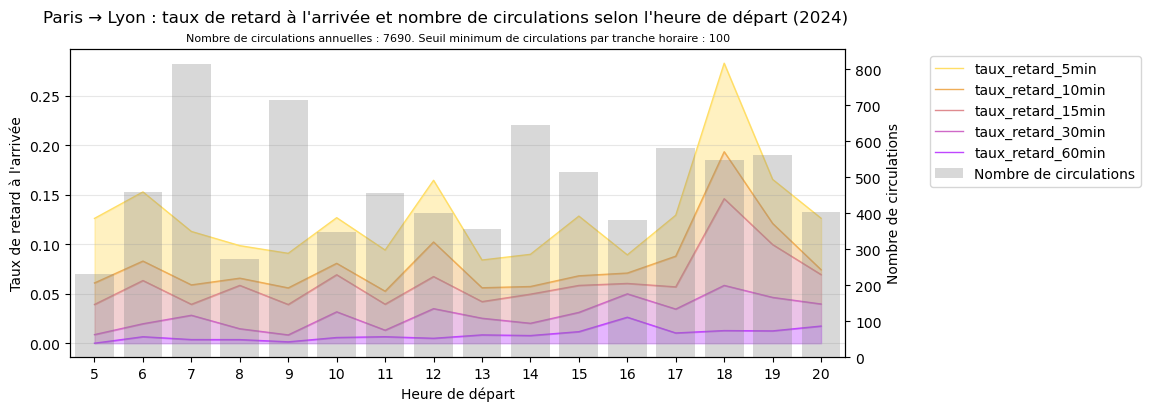

In [35]:
plot_retard_par_heure('Paris', 'Lyon', seuil_trajets_annuels_mini=100)
# Remarque importante : on ne considère dans cette analyse que les terminus. Un train qui serait de passage à Lyon sans y terminer sa course ne sera pas pris en compte.

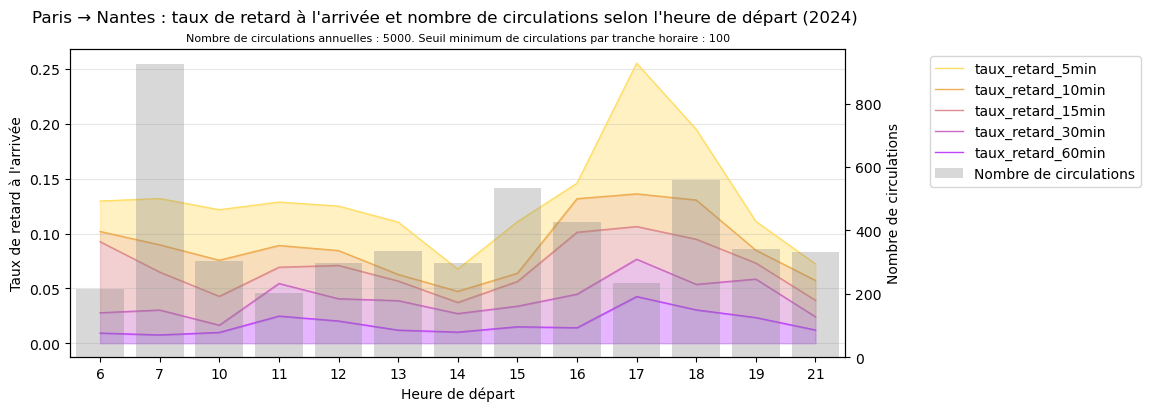

In [36]:
plot_retard_par_heure('Paris', 'Nantes', seuil_trajets_annuels_mini=100)

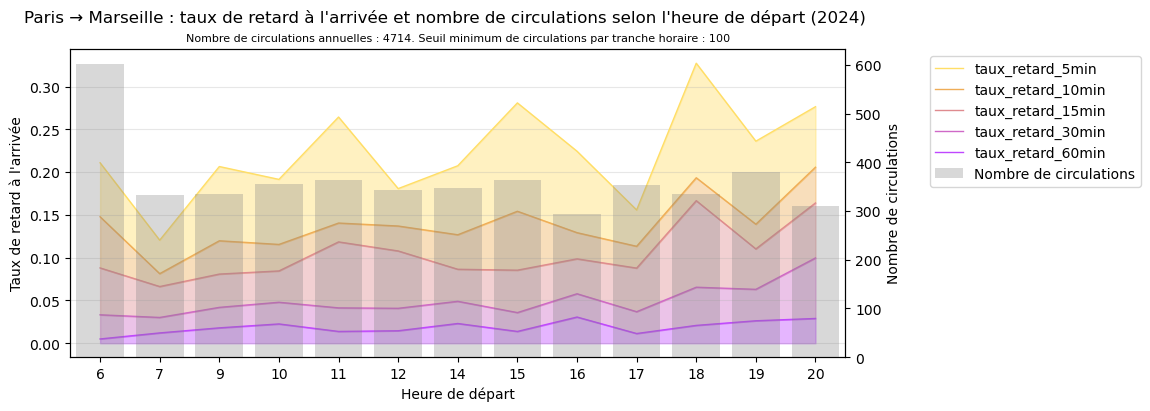

In [37]:
plot_retard_par_heure('Paris', 'Marseille', seuil_trajets_annuels_mini=100)

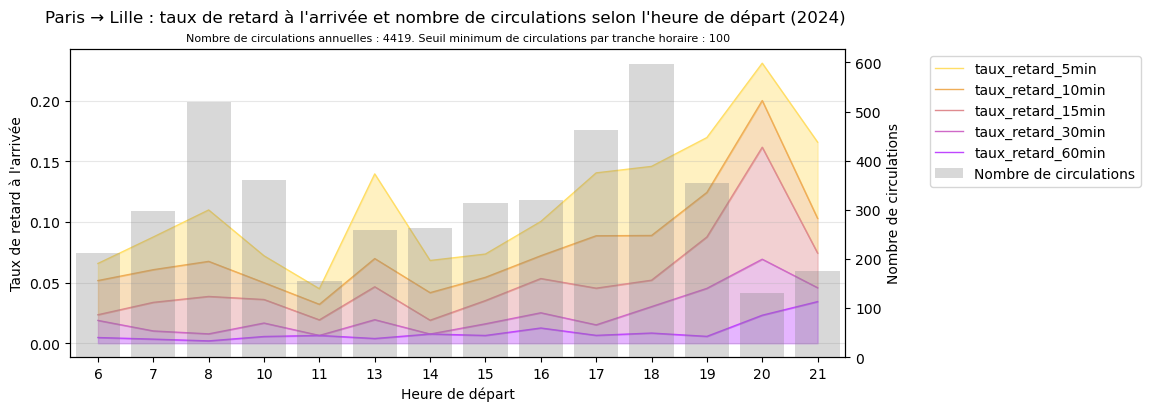

In [38]:
plot_retard_par_heure('Paris', 'Lille', seuil_trajets_annuels_mini=100)

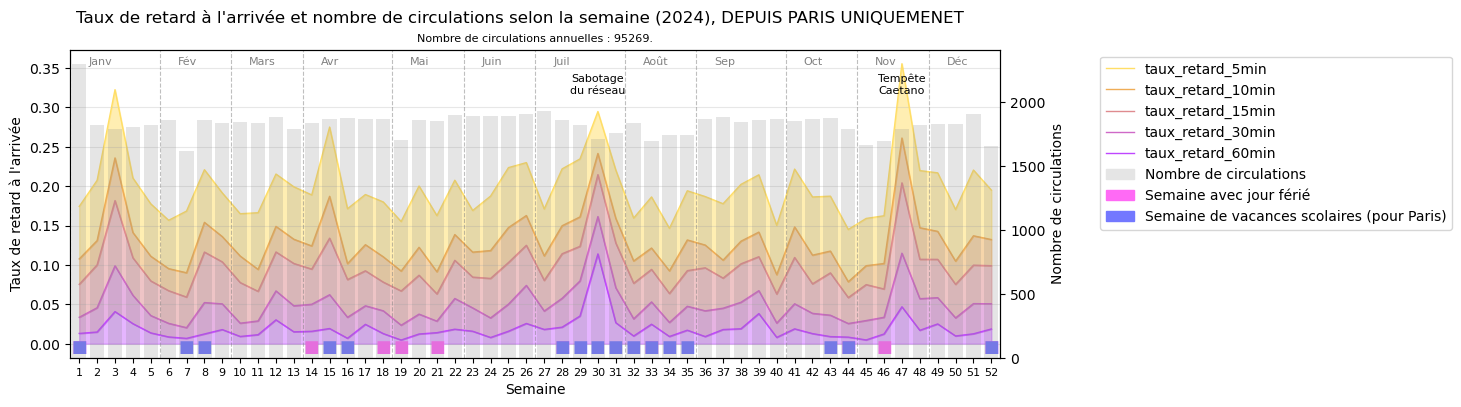

In [39]:
# Impact des vacances scolaires (et jours féries, ponts) sur le taux de retard ?

# Analyser par semaine. Les semaines de vacances seront identifiées pour observer leur effet sur les retards.
# Objectif : graphique du taux de retard (5,10,15,30,60 minutes) par semaine, en précisant lesquelles sont des vacances.

# Restreindre l'analyse au cas de Paris. Trajets vers et depuis Paris uniquement. 

semaines = np.arange(1, 53)
semaines_vacances_paris_2024 = [1, 7, 8, 15, 16, 28, 29, 30, 31, 32, 33, 34, 35, 43, 44, 52] # numéros de semaine des vacances scolaires

jours_feries = pd.read_csv("../data/1-raw/jours_feries/jours_feries_metropole_2005_2030.csv", dtype={"annee": int, "nom_jour_ferie": str}, parse_dates=['date'])
jours_feries_2024 = jours_feries[jours_feries["annee"] == 2024].copy()
jours_feries_2024["week"] = jours_feries_2024["date"].dt.isocalendar().week
jours_feries_2024["day_of_week"] = jours_feries_2024["date"].dt.dayofweek # TODO : retirer les jours fériés qui arrivent le weekend ?
jours_feries_par_semaine = jours_feries_2024.groupby("week").size()

semaine_info = []
for semaine in semaines:
    nb_jours_feries = int(jours_feries_par_semaine.get(semaine, 0))
    is_vacances = semaine in semaines_vacances_paris_2024
    semaine_info.append({
        "num_semaine": semaine,
        "nb_jours_feries": nb_jours_feries,
        "is_vacances": is_vacances
    })
semaine_info_df = pd.DataFrame(semaine_info)

# Trajets depuis Paris uniquement
trajets_depuis_paris = df[(df['lib_ci_origine'].str.startswith('Paris'))]

# Taux de retard à l'arrivée selon la semaine
stats = trajets_depuis_paris.groupby(["num_semaine"]).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# considère la semaine comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(12, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la semaine (2024), DEPUIS PARIS UNIQUEMENET")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}.", fontsize=8)
plt.xlabel("Semaine")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.2, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Pour chaque semaine de vacances & jours fériés, on ajoute un petit carré en bas de la colonne
for semaine in semaine_info_df[semaine_info_df["nb_jours_feries"] > 0]["num_semaine"]:
    if str(semaine) in stats.index:
        ax.text(stats.index.get_loc(str(semaine)), ax.get_ylim()[0]+0.008, "■", fontsize=12, color="#ff6af5", ha='center')
for semaine in semaine_info_df[semaine_info_df["is_vacances"]]["num_semaine"]:
    if str(semaine) in stats.index:
        ax.text(stats.index.get_loc(str(semaine)), ax.get_ylim()[0]+0.008, "■", fontsize=12, color="#7378FF", ha='center')

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
nombre_de_circulations_patch = mpatches.Patch(color="#e5e5e5", label="Nombre de circulations")
handles2 = [nombre_de_circulations_patch]
ferie_patch = mpatches.Patch(color="#ff6af5", label="Semaine avec jour férié")
vacances_patch = mpatches.Patch(color="#7378FF", label="Semaine de vacances scolaires")
ax.legend(handles1 + handles2 + [ferie_patch, vacances_patch], labels1 + labels2 + ["Semaine avec jour férié", "Semaine de vacances scolaires (pour Paris)"], loc="upper left", bbox_to_anchor=(1.1, 1))

# pour chaque mois, ajoute une barre verticale pour séparer les semaines
mois_separateurs = [1, 6, 10, 14, 19, 23, 27, 32, 36, 41, 45, 49]
for sep in mois_separateurs:
    if str(sep) in stats.index:
        ax.axvline(x=stats.index.get_loc(str(sep))-0.5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
# ajoute un label pour chaque mois, en haut du graphique, juste à droite de la barre verticale
mois_labels = ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sep", "Oct", "Nov", "Déc"]
for sep in mois_separateurs:
    if str(sep) in stats.index:
        ax.text(stats.index.get_loc(str(sep))+0.5, ax.get_ylim()[1]*0.95, mois_labels[mois_separateurs.index(sep)], fontsize=8, color='gray')

# Labels axe x (numéros de semaines)
ax.set_xticks(range(len(stats.index)))
ax.set_xticklabels(stats.index, fontsize=8)


# semaine 47 : 'tempête Caetano'
ax.text(stats.index.get_loc('47'), ax.get_ylim()[1]*0.85, "Tempête\nCaetano", fontsize=8, color='black', ha='center')

# semaine 30 : 'Sabotage du réseau'
ax.text(stats.index.get_loc('30'), ax.get_ylim()[1]*0.85, "Sabotage\ndu réseau", fontsize=8, color='black', ha='center')


plt.show()

# constat : 
# vacances scolaires -> pas d'impact systématique. semaines 15, possible lien.
# jours friés -> aucun impact sur les retards.

# 26-28 juillet 2024 (semaine 30)
# - "attaque massive", sabotage coordoné du réseau, incendies volontaires. lignes Atlantique, Nord et Est impactées.
# - https://www.lemonde.fr/economie/article/2024/07/26/sncf-attaque-massive-contre-le-reseau-tgv-le-jour-des-jo_6258709_3234.html

# 20-22 novembre 2024 (semaine 47) 
# - tempête Caetano : épisode hivernal précoce avec neige, verglas et vents violents.
# - https://www.ouest-france.fr/meteo/neige/neige-et-verglas-de-nombreux-trains-en-retard-ou-supprimes-81c3adce-a822-11ef-9190-7abd4499cf18
# - https://www.francebleu.fr/infos/transports/depression-caetano-des-trains-retardes-en-bretagne-a-cause-du-vent-violent-7635508
# - https://meteofrance.com/actualites-et-dossiers/actualites/tempete-caetano-un-episode-hivernal-precoce-avec-neige-en-plaine

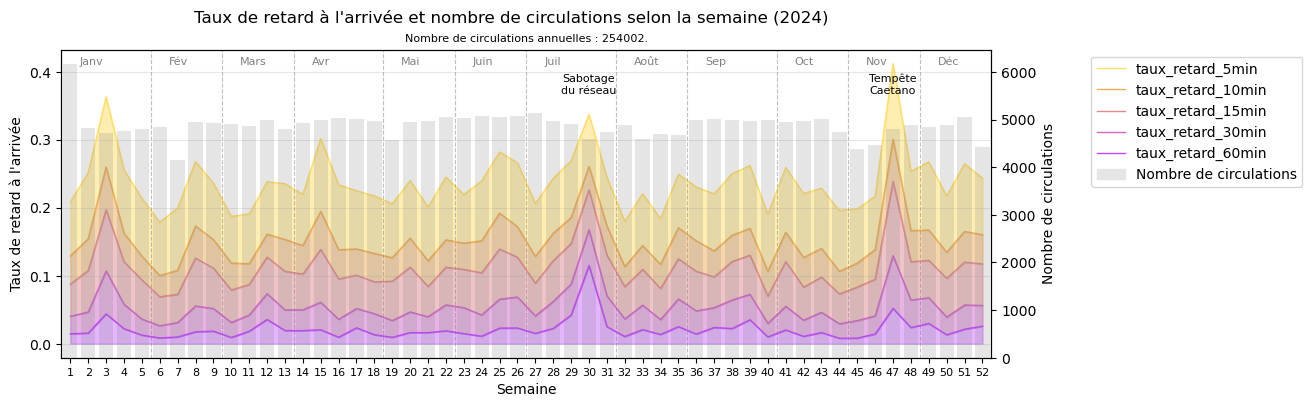

In [40]:
# Graphique plus général, toute origine et destination confonue, mais ans les vacances scolaires (qui n'ont manifestement aucun impact notable)

semaines = np.arange(1, 53)

# Taux de retard à l'arrivée selon la semaine
stats = df.groupby(["num_semaine"]).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# considère la semaine comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# graphique
plt.figure(figsize=(12, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la semaine (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}.", fontsize=8)
plt.xlabel("Semaine")

# taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.2, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# légende
handles1, labels1 = ax.get_legend_handles_labels()
nombre_de_circulations_patch = mpatches.Patch(color="#e5e5e5", label="Nombre de circulations")
handles2 = [nombre_de_circulations_patch]
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# barre verticale entre chaque mois
mois_separateurs = [1, 6, 10, 14, 19, 23, 27, 32, 36, 41, 45, 49]
for sep in mois_separateurs:
    if str(sep) in stats.index:
        ax.axvline(x=stats.index.get_loc(str(sep))-0.5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

# label pour chaque mois
mois_labels = ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sep", "Oct", "Nov", "Déc"]
for sep in mois_separateurs:
    if str(sep) in stats.index:
        ax.text(stats.index.get_loc(str(sep))+0.5, ax.get_ylim()[1]*0.95, mois_labels[mois_separateurs.index(sep)], fontsize=8, color='gray')

# labels axe x (numéros de semaines)
ax.set_xticks(range(len(stats.index)))
ax.set_xticklabels(stats.index, fontsize=8)

# semaine 47 : 'tempête Caetano'
ax.text(stats.index.get_loc('47'), ax.get_ylim()[1]*0.85, "Tempête\nCaetano", fontsize=8, color='black', ha='center')

# semaine 30 : 'Sabotage du réseau'
ax.text(stats.index.get_loc('30'), ax.get_ylim()[1]*0.85, "Sabotage\ndu réseau", fontsize=8, color='black', ha='center')

plt.show()

# constat : 
# vacances scolaires -> impact subtil voire nul sur les retards.
# jours friés -> aucun impact sur les retards.

# 26-28 juillet 2024 (semaine 30)
# - "attaque massive", sabotage coordoné du réseau, incendies volontaires. lignes Atlantique, Nord et Est impactées.
# - https://www.lemonde.fr/economie/article/2024/07/26/sncf-attaque-massive-contre-le-reseau-tgv-le-jour-des-jo_6258709_3234.html

# 20-22 novembre 2024 (semaine 47) 
# - tempête Caetano : épisode hivernal précoce avec neige, verglas et vents violents.
# - https://www.ouest-france.fr/meteo/neige/neige-et-verglas-de-nombreux-trains-en-retard-ou-supprimes-81c3adce-a822-11ef-9190-7abd4499cf18
# - https://www.francebleu.fr/infos/transports/depression-caetano-des-trains-retardes-en-bretagne-a-cause-du-vent-violent-7635508
# - https://meteofrance.com/actualites-et-dossiers/actualites/tempete-caetano-un-episode-hivernal-precoce-avec-neige-en-plaine

# Retard selon trajet (origine, destination)

In [41]:
# origines les plus fréquentes
df["lib_ci_origine"].value_counts().head(10)

lib_ci_origine
Paris-Gare-de-Lyon         33270
Paris-Montparnasse         26608
Paris-Nord                 18768
Paris-Est                  15217
Wannehain                  13588
Lyon-Perrache-Voyageurs    10175
Marseille-St-Charles        8921
Fréthun-Tunnel              8253
Nantes                      7637
Lille-Flandres              6899
Name: count, dtype: Int64

In [42]:
# destinations les plus fréquentes
df["lib_ci_destination"].value_counts().head(10)

lib_ci_destination
Paris-Gare-de-Lyon         32805
Paris-Montparnasse         26759
Paris-Nord                 19262
Paris-Est                  15149
Wannehain                  13027
Marseille-St-Charles        9504
Lyon-Perrache-Voyageurs     9196
Fréthun-Tunnel              8377
Nantes                      7591
Lille-Flandres              6636
Name: count, dtype: Int64

In [43]:
# liste des destinations les plus fréquentes, à partir d'une ville donnée
origine = "Paris"
df[df["lib_ci_origine"].str.startswith(origine)]["lib_ci_destination"].value_counts().head(10)

lib_ci_destination
Lyon-Perrache-Voyageurs    7167
Wannehain                  6767
Fréthun-Tunnel             5191
Nantes                     5106
Marseille-St-Charles       4830
Lille-Flandres             4461
Bordeaux-St-Jean           3311
Quimper                    3074
Pougny-Chancy              2648
La Rochelle-Ville          2641
Name: count, dtype: Int64

In [44]:
# Classement des trajets (num_marche) par taux de retard
retard_num_marche = df.groupby('num_marche').agg(
    lib_ci_origine = ('lib_ci_origine', 'first'),
    lib_ci_destination = ('lib_ci_destination', 'first'),
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).reset_index()
retard_num_marche[retard_num_marche['nb_circ'] > 10].sort_values(by='taux_retard_15min', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,num_marche,lib_ci_origine,lib_ci_destination,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
394,26823,Lyon-Part-Dieu,Montpellier-St-Roch,45.680769,49.050000,1.000000,0.923077,0.923077,0.846154,0.230769,13
448,26986,Chambéry-Challes-les-Eaux,Paris-Gare-de-Lyon,47.758824,35.900000,0.764706,0.764706,0.764706,0.529412,0.294118,17
2232,9362,Wannehain,Paris-Nord,35.692157,23.450000,0.764706,0.647059,0.647059,0.470588,0.235294,17
436,26920,Lyon-St-Exupéry-TGV,Paris-Gare-de-Lyon,24.189815,16.925000,0.722222,0.611111,0.611111,0.388889,0.111111,18
308,26514,Bordeaux-St-Jean,Paris-Montparnasse,48.619444,31.025000,0.583333,0.583333,0.583333,0.583333,0.250000,12
416,26864,Lyon-Part-Dieu,Marne-la-Vallée-Chessy,34.804762,27.558333,0.785714,0.642857,0.571429,0.500000,0.142857,14
366,26702,Rennes,Paris-Montparnasse,30.992063,21.883333,0.714286,0.619048,0.571429,0.476190,0.190476,21
2273,9468,Stiring-Wendel,Paris-Est,37.400758,19.975000,0.647727,0.613636,0.568182,0.386364,0.250000,88
230,26194,Lyon-St-Exupéry-TGV,Paris-Gare-de-Lyon,26.018182,18.316667,0.727273,0.636364,0.545455,0.363636,0.090909,11
368,26706,Rennes,Paris-Montparnasse,35.263158,18.250000,0.789474,0.684211,0.526316,0.263158,0.157895,19


In [45]:
"""plt.figure(figsize=(10, 4))
plt.title("Nombre de circulations par num_marche")
sns.histplot(data=retard_num_marche, x='nb_circ', binwidth=10)
plt.show()"""

'plt.figure(figsize=(10, 4))\nplt.title("Nombre de circulations par num_marche")\nsns.histplot(data=retard_num_marche, x=\'nb_circ\', binwidth=10)\nplt.show()'

In [46]:
# Deuxième approche : classement des trajets (origine-destination) par taux de retard (ayant circulé au moins n fois sur l'année) 
# #TODO fitrer plutot sur le type de gare (A,B,C)
# en effet, certaines gares peuvent être reliées par plusieurs trajets (num_marche) différents

df_copy = df.copy()
df_copy['origine-destination'] = df_copy['lib_ci_origine'] + " → " + df_copy['lib_ci_destination']
retard_origine_destination = df_copy.groupby('origine-destination').agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
retard_origine_destination[retard_origine_destination['nb_circ'] > 100].sort_values(by='taux_retard_60min', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Nancy-Ville → Nice-Ville,20.330945,5.491667,0.524390,0.393293,0.341463,0.198171,0.091463,328
Arras → Paris-Nord,24.124812,4.900000,0.496241,0.398496,0.345865,0.233083,0.090226,133
Montpellier-St-Roch → Wannehain,21.657629,12.650000,0.653061,0.568513,0.431487,0.244898,0.081633,343
Marseille-St-Charles → Metz-Ville,17.241503,5.433333,0.500000,0.372549,0.294118,0.176471,0.078431,102
Valence-TGV → Marseille-St-Charles,16.750728,5.266667,0.519417,0.349515,0.271845,0.155340,0.067961,206
Nantes → Lille-Europe,12.612288,3.650000,0.398305,0.231638,0.172316,0.104520,0.062147,354
Lorient → Paris-Montparnasse,13.661497,4.366667,0.457143,0.310204,0.232653,0.142857,0.061224,245
Roissy-Aéroport-CDG 2 → Toulon,10.279190,0.108333,0.251429,0.211429,0.168571,0.120000,0.060000,350
Bordeaux-St-Jean → Tourcoing,12.897929,2.000000,0.431953,0.372781,0.269231,0.121302,0.059172,338


In [47]:
# trajets les plus en retard depuis Paris (ayant circulé au moins 100 fois sur l'année) #TODO fitrer plutot sur le type de gare (A,B,C)
stats = retard_origine_destination
stats[stats.index.str.startswith("Paris") & (stats['nb_circ'] > 100)].sort_values(by='taux_retard_60min', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Paris-Gare-de-Lyon → Toulon,9.300203,0.758333,0.289634,0.198171,0.149390,0.079268,0.045732,328
Paris-Gare-de-Lyon → Nice-Ville,13.103469,3.266667,0.410819,0.279890,0.212858,0.117993,0.045080,2551
Paris-Gare-de-Lyon → Lyon-Part-Dieu,7.250431,0.000000,0.174950,0.137177,0.123260,0.093439,0.041750,503
Paris-Montparnasse → St-Nazaire,9.439063,0.500000,0.265625,0.193750,0.162500,0.087500,0.040625,320
Paris-Montparnasse → Toulouse-Matabiau,6.726999,-0.900000,0.241179,0.172398,0.139795,0.085753,0.037070,2239
Paris-Est → Thionville,7.064634,1.466667,0.211382,0.113821,0.081301,0.048780,0.032520,123
Paris-Gare-de-Lyon → Perpignan,6.295083,-0.066667,0.267824,0.189962,0.139306,0.063790,0.025797,2132
Paris-Austerlitz → Nantes,4.764537,-1.083333,0.158889,0.123333,0.100000,0.067778,0.025556,900
Paris-Montparnasse → Hendaye,5.259538,-1.000000,0.186996,0.132187,0.108544,0.054272,0.025255,1861


In [48]:
# trajets les plus fréquents depuis Paris
stats = retard_origine_destination
stats[stats.index.str.startswith("Paris")].sort_values(by='nb_circ', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Paris-Gare-de-Lyon → Lyon-Perrache-Voyageurs,2.961741,0.100000,0.127128,0.077611,0.058031,0.024688,0.006527,7048
Paris-Nord → Wannehain,6.010399,0.966667,0.199793,0.142604,0.114674,0.060588,0.022019,6767
Paris-Nord → Fréthun-Tunnel,5.438666,0.033333,0.206126,0.160085,0.128492,0.072048,0.023310,5191
Paris-Gare-de-Lyon → Marseille-St-Charles,6.145403,1.183333,0.222820,0.142058,0.106026,0.051149,0.019466,4829
Paris-Nord → Lille-Flandres,2.479134,-0.033333,0.114997,0.076440,0.049092,0.021744,0.008294,4461
Paris-Montparnasse → Nantes,3.929936,-0.500000,0.135638,0.092253,0.072706,0.039571,0.017878,4195
Paris-Montparnasse → Bordeaux-St-Jean,6.037269,1.233333,0.262776,0.151497,0.102812,0.047777,0.022074,3307
Paris-Montparnasse → Quimper,5.439775,0.000000,0.196679,0.139694,0.109085,0.057636,0.021817,3071
Paris-Gare-de-Lyon → Pougny-Chancy,7.388904,1.541667,0.242069,0.174471,0.137840,0.057402,0.016616,2648


In [49]:
# trajets les plus fréquents
retard_origine_destination.sort_values(by='nb_circ', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Lyon-Perrache-Voyageurs → Paris-Gare-de-Lyon,3.652288,0.683333,0.166467,0.098840,0.071228,0.031613,0.008670,7497
Wannehain → Paris-Nord,12.502261,4.333333,0.477188,0.355341,0.269469,0.124742,0.037767,7255
Paris-Gare-de-Lyon → Lyon-Perrache-Voyageurs,2.961741,0.100000,0.127128,0.077611,0.058031,0.024688,0.006527,7048
Paris-Nord → Wannehain,6.010399,0.966667,0.199793,0.142604,0.114674,0.060588,0.022019,6767
Paris-Nord → Fréthun-Tunnel,5.438666,0.033333,0.206126,0.160085,0.128492,0.072048,0.023310,5191
Fréthun-Tunnel → Paris-Nord,6.013017,1.516667,0.284213,0.182792,0.121666,0.057037,0.020635,5137
Paris-Gare-de-Lyon → Marseille-St-Charles,6.145403,1.183333,0.222820,0.142058,0.106026,0.051149,0.019466,4829
Paris-Nord → Lille-Flandres,2.479134,-0.033333,0.114997,0.076440,0.049092,0.021744,0.008294,4461
Lille-Flandres → Paris-Nord,3.452256,1.033333,0.153618,0.074412,0.051815,0.021913,0.007761,4381


In [50]:
#plt.figure(figsize=(10, 4))
#plt.title("Nombre de circulations par origine-destination")
#sns.histplot(data=retard_origine_destination, x='nb_circ')
#plt.show()

# Retard selon compagnie (lib_ui)

In [51]:
# Taux de retard selon la compagnie ferroviaire (lib_ui)
retard_compagnie = df.groupby("lib_ui").agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
retard_compagnie.sort_values(by='taux_retard_5min', ascending=False).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
lib_ui,,,,,,,,
SNCF VOYAGES ITALIA,7.298908,1.875000,0.325862,0.175862,0.108621,0.058621,0.018966,580
RENFE VIAJEROS,7.738447,1.666667,0.300493,0.178747,0.124560,0.068262,0.024631,1421
THI FACTORY,7.578523,1.433333,0.298029,0.211669,0.158615,0.077320,0.025517,31195
SNCF-VOYAGES,6.147205,0.866667,0.231949,0.146087,0.105780,0.051600,0.020619,214030
SNCF-VOYAGEURS,5.450589,0.000000,0.190813,0.159011,0.120141,0.067138,0.035336,283
OSLO,4.921027,-0.316667,0.160354,0.112566,0.089558,0.055929,0.024071,2825
TRENITALIA FRANCE,2.310896,-0.200000,0.112868,0.066249,0.050981,0.025900,0.008451,3668


# retard selon météo

In [52]:
# import des données météo france 2024
meteo = pd.read_parquet("../data/2-clean/meteo/meteo_france_2024.parquet")

# drop les colonnes avec trop peu de données : tornado et hail
meteo = meteo.drop(columns=['tornado', 'hail'])

In [53]:
# Complète le df principal via jointure sur 'region' et 'DATE' 
df_copy = df.copy()
df_copy = df_copy.merge(meteo, how='left', left_on=['region_destination', 'date_circ'], right_on=['region', 'DATE'])

<Axes: >

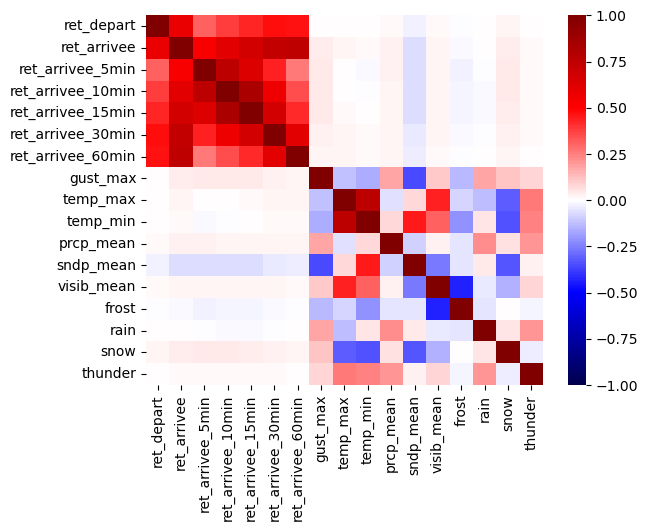

In [54]:
# Heatmap de corrélation des variables de retard et la météo
corr_map = df_copy[['ret_depart', 'ret_arrivee', 'ret_arrivee_5min', 'ret_arrivee_10min', 'ret_arrivee_15min', 'ret_arrivee_30min', 'ret_arrivee_60min', 
                   'gust_max', 'temp_max', 'temp_min', 'prcp_mean', 'sndp_mean', 'visib_mean', 'frost', 'rain', 'snow', 'thunder']].corr()

sns.heatmap(corr_map, annot=False, fmt=".2f", cmap="seismic", vmax=1, vmin=-1)
# constat : à première vue, aucune corrélation majeure entre les variables de retard et les variables météorologiques


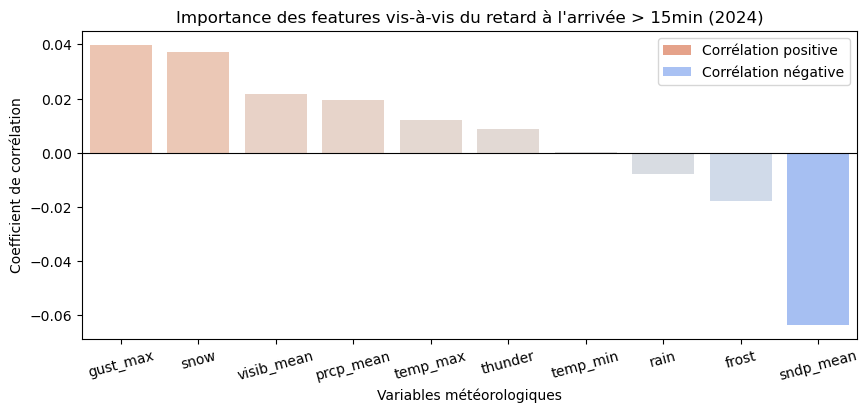

In [64]:
# Importance des variables météorologiques vis-à-vis du retard à l'arrivée > 15min
corr_series = corr_map.loc["ret_arrivee_15min"].sort_values(ascending=False)
# on exclut les colonnes non pertinentes (directement liées au retard à l'arrivée) :
corr_series = corr_series.drop(["ret_depart", "ret_arrivee_60min", "ret_arrivee_30min", "ret_arrivee_15min", "ret_arrivee_10min", "ret_arrivee_5min", "ret_arrivee"], errors='ignore')

# dégradé de couleurs
norm = plt.Normalize(-0.15, 0.15)
colors = (plt.cm.coolwarm(norm(corr_series.values))).tolist()

# graphique
plt.figure(figsize=(10, 4))
sns.barplot(x=corr_series.index,
            y=corr_series.values,
            hue=corr_series.index,
            palette=colors)
plt.xticks(rotation=15, ha='center')
plt.title("Importance des features vis-à-vis du retard à l'arrivée > 15min (2024)")
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

# légende
legend_elements = [Patch(facecolor="#e5a28a", label='Corrélation positive'),
                   Patch(facecolor="#a9c1f3", label='Corrélation négative')]
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel("Variables météorologiques")
plt.ylabel("Coefficient de corrélation")

plt.show()

# Constat : les corrélations semblent quasi nulles, car comprises entre -0.06 et 0.04
# seule la neige, les rafales de vent, et dans une moindre mesure les précipitations, semblent avoir un léger impact sur les retards.
# à compléter avec une analyse plus fine (conditions extremes de température, etc)

In [56]:
# Taux de retard selon la hauteur de neige

# D'abord, analyse de la répartition de la hauteur de neige
# plt.figure(figsize=(4, 2))
# sns.histplot(df_copy['sndp_mean'].dropna(), bins=100, kde=False)
# df_copy['sndp_mean'].describe()

# répartit la hauteur de neige en catégories
df_snow = df_copy.copy()
df_snow['sndp_mean'] = df_snow['sndp_mean'].fillna(0)
bins = [0, 1, 20, 100, float('inf')]
labels = ['0', '0-20', '20-100', '100+']
df_snow['sndp_cat'] = pd.cut(df_snow['sndp_mean'], bins=bins, labels=labels, right=False)

# taux de retard selon la hauteur de neige
stats = df_snow.groupby('sndp_cat', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

stats

# constat : résultat à prendre avec des pincettes, car phénomène relativement rare (peu de données), stations météo potentiellement 
# plus exposées à la neige selon leur emplacement, phénomène potentiellement très localisé... difficle de généraliser.
# entre 0 et 20cm de neige : légère augmentation des retards
# entre 20 et 100cm de neige : augmentation plus prononcée
# au delà de 100 : ??

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
sndp_cat,,,,,,,,
0,6.22,0.87,0.23,0.15,0.11,0.05,0.02,236075
0-20,6.88,1.38,0.28,0.18,0.13,0.06,0.02,17764
20-100,1.51,0.18,0.11,0.06,0.03,0.02,0.00,154
100+,-0.37,-0.92,0.11,0.00,0.00,0.00,0.00,9


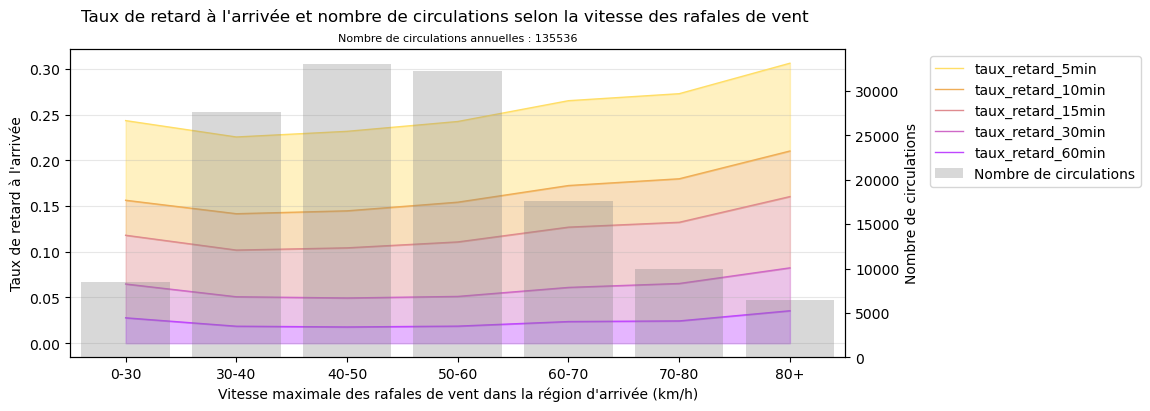

In [74]:
# répartit les rafales de vent en catégories
df_gust = df_copy.copy()
#df_gust['gust_max'] = df_gust['gust_max'].fillna(0)
bins = [0, 30, 40, 50, 60, 70, 80, float('inf')]
labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
df_gust['gust_cat'] = pd.cut(df_gust['gust_max'], bins=bins, labels=labels, right=False)

# taux de retard selon la vitesse des rafales
stats = df_gust.groupby('gust_cat', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

stats

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la vitesse des rafales de vent")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Vitesse maximale des rafales de vent dans la région d'arrivée (km/h)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()



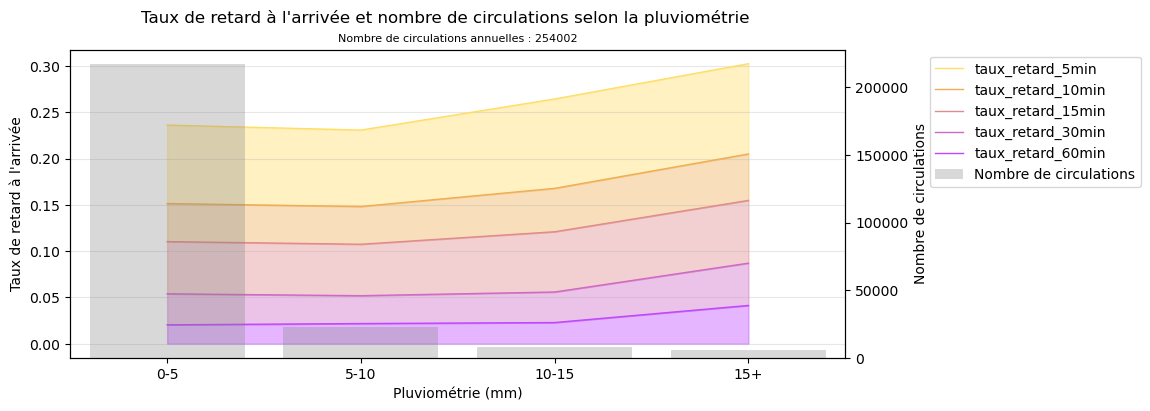

In [71]:
# taux de retard selon la pluviométrie :

# Répartition de la pluviométrie
# plt.figure(figsize=(4, 2))
# sns.histplot(df_copy['prcp_mean'].dropna(), bins=30, kde=False)
# df_copy['prcp_mean'].describe()

# répartit la pluviométrie en catégories
df_prcp = df_copy.copy()
df_prcp['prcp_mean'] = df_prcp['prcp_mean'].fillna(0)
bins = [0, 5, 10, 15, float('inf')]
labels = ['0-5', '5-10', '10-15', '15+']
df_prcp['prcp_mean'] = pd.cut(df_prcp['prcp_mean'], bins=bins, labels=labels, right=False)

# taux de retard selon la pluviométrie
stats = df_prcp.groupby('prcp_mean', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la pluviométrie")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Pluviométrie (mm)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# constat : légère augmentation du taux de retard lors de phénomènes pluvieux importants.

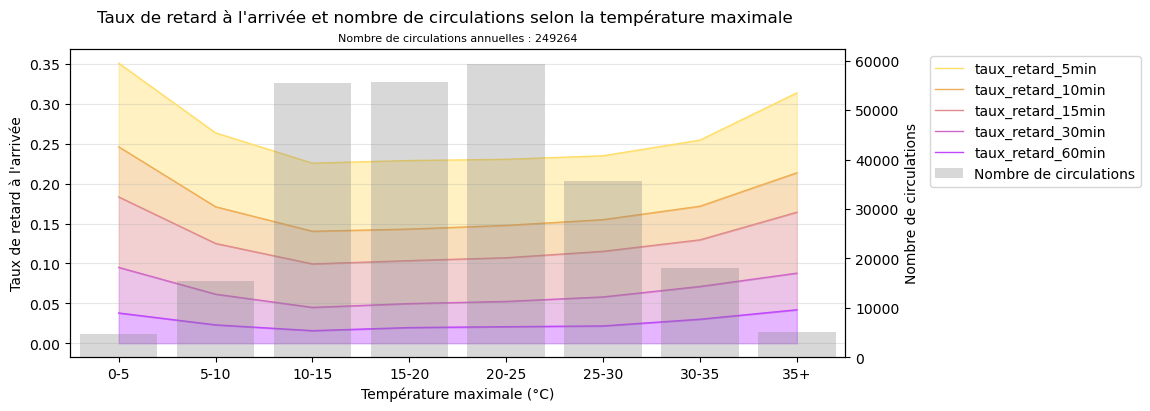

In [66]:
# taux de retard selon la température max

# effet attendu : retards causés par températures extremes (causant dilatation des rails, etc)

# D'abord, analyse de la répartition de la température
# plt.figure(figsize=(4, 2))
# sns.histplot(df_copy['temp_max'].dropna(), bins=10, kde=False)
# df_copy['temp_max'].describe()

# répartit la température max en catégories
df_temp_max = df_copy.copy()
bins = [0, 5, 10, 15, 20, 25, 30, 35, float('inf')]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
df_temp_max['temp_max'] = pd.cut(df_temp_max['temp_max'], bins=bins, labels=labels, right=False)

# taux de retard selon la température max
stats = df_temp_max.groupby('temp_max', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la température maximale")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Température maximale (°C)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# constat :
# - le taux de retard augmente significativement lorsque les températures max sont faibles (<5°C), et lorsqu'elles sont élevées (>30°C)

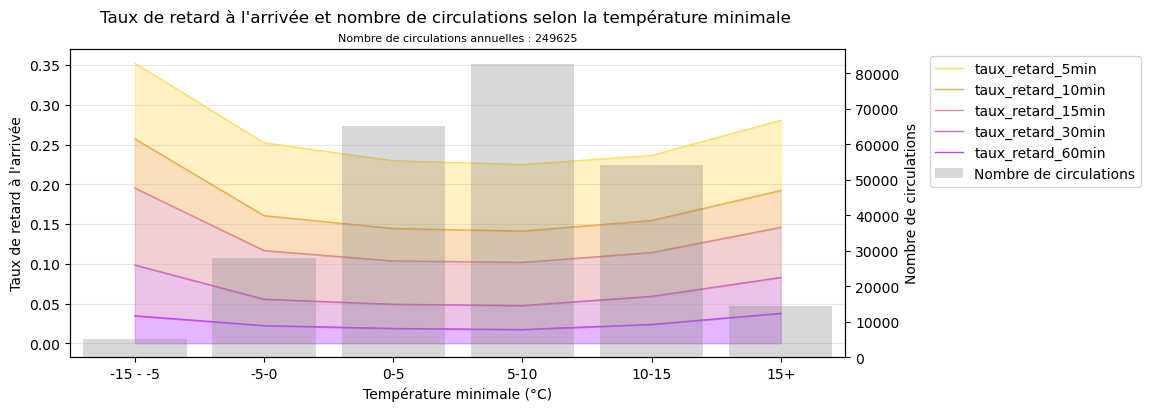

In [67]:
# taux de retard selon la température min

# effet attendu : retards causés par températures extremes (causant dilatation des rails, etc)

# D'abord, analyse de la répartition de la température
# plt.figure(figsize=(4, 2))
# sns.histplot(df_copy['temp_min'].dropna(), bins=10, kde=False)
# df_copy['temp_min'].describe()

# répartit la température min en catégories
df_temp_min = df_copy.copy()
bins = [-15, -5, 0, 5, 10, 15, float('inf')]
labels = ['-15 - -5', '-5-0', '0-5', '5-10', '10-15', '15+']
df_temp_min['temp_min'] = pd.cut(df_temp_min['temp_min'], bins=bins, labels=labels, right=False)


# taux de retard selon la température min
stats = df_temp_min.groupby('temp_min', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la température minimale")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Température minimale (°C)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()


In [61]:
# taux de retard selon la visibilité -> aucun lien pertinent.

"""# D'abord, analyse de la répartition de la visibilité
plt.figure(figsize=(4, 2))
sns.histplot(df_copy['visib_mean'].dropna(), bins=10, kde=True)
df_copy['visib_mean'].describe()


# répartit la visibilité  en catégories
df_visib = df_copy.copy()
df_visib['visib_mean'] = df_visib['visib_mean'].fillna(0)
bins = [0, 10, 11, 12, 13, 14, 15, float('inf')]
labels = ['0-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15+']
df_visib['visib_mean'] = pd.cut(df_visib['visib_mean'], bins=bins, labels=labels, right=False)

# taux de retard selon la température min
stats = df_visib.groupby('visib_mean', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la visibilité moyenne")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Visibilité moyenne (km)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# aucun impact pertinent. La visibilité étant corrélée à la température, c'est pobablement plutôt la température qui a un impact.
# une visibilité superieur n'a aucune raison d'augmenter le retard d'un train.

plt.show()"""

'# D\'abord, analyse de la répartition de la visibilité\nplt.figure(figsize=(4, 2))\nsns.histplot(df_copy[\'visib_mean\'].dropna(), bins=10, kde=True)\ndf_copy[\'visib_mean\'].describe()\n\n\n# répartit la visibilité  en catégories\ndf_visib = df_copy.copy()\ndf_visib[\'visib_mean\'] = df_visib[\'visib_mean\'].fillna(0)\nbins = [0, 10, 11, 12, 13, 14, 15, float(\'inf\')]\nlabels = [\'0-10\', \'10-11\', \'11-12\', \'12-13\', \'13-14\', \'14-15\', \'15+\']\ndf_visib[\'visib_mean\'] = pd.cut(df_visib[\'visib_mean\'], bins=bins, labels=labels, right=False)\n\n# taux de retard selon la température min\nstats = df_visib.groupby(\'visib_mean\', observed=False).agg(\n    retard_arrivee_moyen = (\'ret_arrivee\', \'mean\'),\n    retard_arrivee_median = (\'ret_arrivee\', \'median\'),\n    taux_retard_5min = (\'ret_arrivee_5min\', \'mean\'),\n    taux_retard_10min = (\'ret_arrivee_10min\', \'mean\'),\n    taux_retard_15min = (\'ret_arrivee_15min\', \'mean\'),\n    taux_retard_30min = (\'ret_arrive

In [62]:
# taux de retard en fonction des conditions météo (booléennes) dans la région d'arrivée
for event in ['thunder', 'snow', 'rain', 'frost']:
    stats = df_copy.groupby(event).agg(
        retard_arrivee_moyen = ('ret_arrivee', 'mean'),
        retard_arrivee_median = ('ret_arrivee', 'median'),
        taux_retard_5min = ('ret_arrivee_5min', 'mean'),
        taux_retard_10min = ('ret_arrivee_10min', 'mean'),
        taux_retard_15min = ('ret_arrivee_15min', 'mean'),
        taux_retard_30min = ('ret_arrivee_30min', 'mean'),
        taux_retard_60min = ('ret_arrivee_60min', 'mean'),
        nb_circ = ('id_circ', 'count')
    )
    print(f"Stats for {event}:")
    display(stats)

# constat : 
# - la présence de neige semble augmenter significativement les retards, toute catégorie de retard confondue (médian, moyen, 5min, 10min, etc)
# - orages, pluie, gel : impact non significatif
# analyses à affiner avec les variables continues (quantité de pluie, vitesse du vent, températures, etc... voir l'impact des canicules)

Stats for thunder:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
thunder,,,,,,,,
False,6.17,0.90,0.24,0.15,0.11,0.05,0.02,218352
True,6.88,0.93,0.25,0.16,0.12,0.06,0.02,31273


Stats for snow:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
snow,,,,,,,,
False,6.10,0.87,0.23,0.15,0.11,0.05,0.02,237498
True,9.21,1.57,0.31,0.22,0.16,0.08,0.03,12127


Stats for rain:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
rain,,,,,,,,
False,6.15,0.92,0.24,0.16,0.12,0.06,0.02,60276
True,6.29,0.90,0.24,0.15,0.11,0.05,0.02,189349


Stats for frost:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
frost,,,,,,,,
False,6.47,1.00,0.25,0.16,0.12,0.06,0.02,150974
True,5.93,0.73,0.22,0.14,0.10,0.05,0.02,98651


In [63]:
# idée : calculer à nouveau la matrice de corrélation, mais au lieu de fournir temp_max, on founrir temp_max_cat

"""# rafales de vent
df_copy['gust_max'] = df_copy['gust_max'].fillna(0)
bins = [0, 30, 40, 50, 60, 70, 80, float('inf')]
labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
df_copy['gust_cat'] = pd.cut(df_copy['gust_max'], bins=bins, labels=labels, right=False)

# pluviométrie
df_copy['prcp_mean'] = df_copy['prcp_mean'].fillna(0)
bins = [0, 5, 10, 15, float('inf')]
labels = ['0-5', '5-10', '10-15', '15+']
df_copy['prcp_cat'] = pd.cut(df_copy['prcp_mean'], bins=bins, labels=labels, right=False)

# température max
df_copy['temp_max'] = df_copy['temp_max'].fillna(0)
bins = [0, 5, 10, 15, 20, 25, 30, 35, float('inf')]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
df_copy['temp_max_cat'] = pd.cut(df_copy['temp_max'], bins=bins, labels=labels, right=False)

# température min
df_copy['temp_min'] = df_copy['temp_min'].fillna(0)
bins = [-15, -5, 0, 5, 10, 15, float('inf')]
labels = ['-15 - -5', '-5-0', '0-5', '5-10', '10-15', '15+']
df_copy['temp_min_cat'] = pd.cut(df_copy['temp_min'], bins=bins, labels=labels, right=False)

# encodage des variables catégorielles en numériques pour la corrélation
df_copy["gust_cat_code"] = df_copy["gust_cat"].cat.codes
df_copy["prcp_cat_code"] = df_copy["prcp_cat"].cat.codes
df_copy["temp_max_cat_code"] = df_copy["temp_max_cat"].cat.codes
df_copy["temp_min_cat_code"] = df_copy["temp_min_cat"].cat.codes

# Heatmap de corrélation des variables
corr_map = df_copy[['ret_depart', 'ret_arrivee', 'ret_arrivee_5min', 'ret_arrivee_10min', 
                    'ret_arrivee_15min', 'ret_arrivee_30min', 'ret_arrivee_60min', 
                    'gust_cat_code', 'temp_max_cat_code', 'temp_min_cat_code', 'prcp_cat_code', 'sndp_mean']].corr()

sns.heatmap(corr_map, annot=False, fmt=".2f", cmap="seismic", vmax=1, vmin=-1)"""

# constat : c'est confirmé, ça ne change absolument rien
# les corrélations sont faibles car les phénomènes météo extêmes sont beaucoup moins fréquents que les conditions météo normales
# pour avoir des corrélations plus marquées, il faudrait rééchantillonner les données en gardant les mêmes proportions pour chaque catégorie météo
# ou alors faire une analyse ciblée sur les jours avec conditions météo extrêmes uniquement

'# rafales de vent\ndf_copy[\'gust_max\'] = df_copy[\'gust_max\'].fillna(0)\nbins = [0, 30, 40, 50, 60, 70, 80, float(\'inf\')]\nlabels = [\'0-30\', \'30-40\', \'40-50\', \'50-60\', \'60-70\', \'70-80\', \'80+\']\ndf_copy[\'gust_cat\'] = pd.cut(df_copy[\'gust_max\'], bins=bins, labels=labels, right=False)\n\n# pluviométrie\ndf_copy[\'prcp_mean\'] = df_copy[\'prcp_mean\'].fillna(0)\nbins = [0, 5, 10, 15, float(\'inf\')]\nlabels = [\'0-5\', \'5-10\', \'10-15\', \'15+\']\ndf_copy[\'prcp_cat\'] = pd.cut(df_copy[\'prcp_mean\'], bins=bins, labels=labels, right=False)\n\n# température max\ndf_copy[\'temp_max\'] = df_copy[\'temp_max\'].fillna(0)\nbins = [0, 5, 10, 15, 20, 25, 30, 35, float(\'inf\')]\nlabels = [\'0-5\', \'5-10\', \'10-15\', \'15-20\', \'20-25\', \'25-30\', \'30-35\', \'35+\']\ndf_copy[\'temp_max_cat\'] = pd.cut(df_copy[\'temp_max\'], bins=bins, labels=labels, right=False)\n\n# température min\ndf_copy[\'temp_min\'] = df_copy[\'temp_min\'].fillna(0)\nbins = [-15, -5, 0, 5, 10, 1